<a href="https://colab.research.google.com/github/nericovich/project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект для задачи Яндекс Лицея "Анализ экологических проблем"

### На заводе по производству полезного полимера ООО “Synthesising the future“ обратились за помощью в исследовании зависимостей вредных выбросов от производственных показателей. Требуется повести анализ данных и построить выводы о том, какой этап имеет высокий риск создать повышенное содержания вредного газа.


## Импорты

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
import seaborn as sns
import math
from statistics import mode
from scipy.stats import mannwhitneyu, ttest_ind, shapiro, pointbiserialr, spearmanr

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer

from catboost import CatBoostRegressor

In [152]:
df = pd.read_csv('data.csv', sep=',', decimal='.', skipinitialspace=True)
df.dropna(subset='work_shift', inplace=True) #  Там где нет смены, там нет и данных (знаем)
df.shape

(4240, 24)

### Стили

In [153]:
sns.set_theme(style="darkgrid")
color_for_histplot = '#92B755'
line={"color": "#0b412e", "linewidth": 2}
corporate_colors = ["#92B755", "#133215", "#F3E8D3"]
color_for_line = '#133215'
for_hue_palette = ['#006145', '#abbb60']

## Исследование данных на качество


### Исследование типов данных 

In [154]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [155]:
df.head(4)

datetime  stage_1_output_konv_avd  stage_2_input_water_sum  \
0  2021-01-28 18:00:00                    67.83                    92.99   
1  2021-01-28 19:00:00                    67.83                    91.82   
2  2021-01-28 20:00:00                    67.83                    90.65   
3  2021-01-28 21:00:00                    67.93                    90.24   

   stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
0                          474.18                       76.84   
1                          473.68                       76.15   
2                          473.17                       75.46   
3                          473.59                       75.26   

   stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
0                                 97.52                         49.94   
1                                 97.82                         48.55   
2                                 98.12                         47.15   
3                                 97.79                         49.33   

   stage_2_output_top_pressure  stage_2_output_top_pressure_at_end  \
0                       361.50                              252.04   
1                       354.75                              244.87   
2                       348.00                              237.70   
3                       356.74                              249.87   

   stage_2_output_top_temp  ...  stage_3_output_temp_hum_steam  \
0                    97.48  ...                         108.65   
1                    97.66  ...                         108.71   
2                    97.85  ...                         108.76   
3                    97.50  ...                         108.63   

   stage_3_output_temp_top  stage_4_input_overheated_steam  \
0                    45.59                          156.67   
1                    45.89                          156.76   
2                    46.19                          156.86   
3                    45.87                          156.41   

   stage_4_input_polymer  stage_4_input_steam  stage_4_input_water  \
0                  19.08                 5.92               356.05   
1                  19.15                 5.94               357.69   
2                  19.23                 5.97               359.33   
3                  19.36                 5.97               339.99   

   stage_4_output_danger_gas  stage_4_output_dry_residue_avg  \
0                        NaN                           21.48   
1                        NaN                           21.48   
2                        NaN                           21.48   
3                       0.16                           21.48   

   stage_4_output_product  work_shift  
0                   47.03         2.0  
1                   45.05         2.0  
2                   43.06         2.0  
3                   46.01         2.0  

[4 rows x 24 columns]

Типы данных

In [156]:
df.dtypes

datetime                                 object
stage_1_output_konv_avd                 float64
stage_2_input_water_sum                 float64
stage_2_output_bottom_pressure          float64
stage_2_output_bottom_temp              float64
stage_2_output_bottom_temp_hum_steam    float64
stage_2_output_bottom_vacuum            float64
stage_2_output_top_pressure             float64
stage_2_output_top_pressure_at_end      float64
stage_2_output_top_temp                 float64
stage_2_output_top_vacuum               float64
stage_3_input_pressure                  float64
stage_3_input_soft_water                float64
stage_3_input_steam                     float64
stage_3_output_temp_hum_steam           float64
stage_3_output_temp_top                 float64
stage_4_input_overheated_steam          float64
stage_4_input_polymer                   float64
stage_4_input_steam                     float64
stage_4_input_water                     float64
stage_4_output_danger_gas               

Заметим, что у нас work_shift - по сути бинарная шкала.

In [157]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.dtypes

datetime                                datetime64[ns]
stage_1_output_konv_avd                        float64
stage_2_input_water_sum                        float64
stage_2_output_bottom_pressure                 float64
stage_2_output_bottom_temp                     float64
stage_2_output_bottom_temp_hum_steam           float64
stage_2_output_bottom_vacuum                   float64
stage_2_output_top_pressure                    float64
stage_2_output_top_pressure_at_end             float64
stage_2_output_top_temp                        float64
stage_2_output_top_vacuum                      float64
stage_3_input_pressure                         float64
stage_3_input_soft_water                       float64
stage_3_input_steam                            float64
stage_3_output_temp_hum_steam                  float64
stage_3_output_temp_top                        float64
stage_4_input_overheated_steam                 float64
stage_4_input_polymer                          float64
stage_4_in

### Исследование выбросов

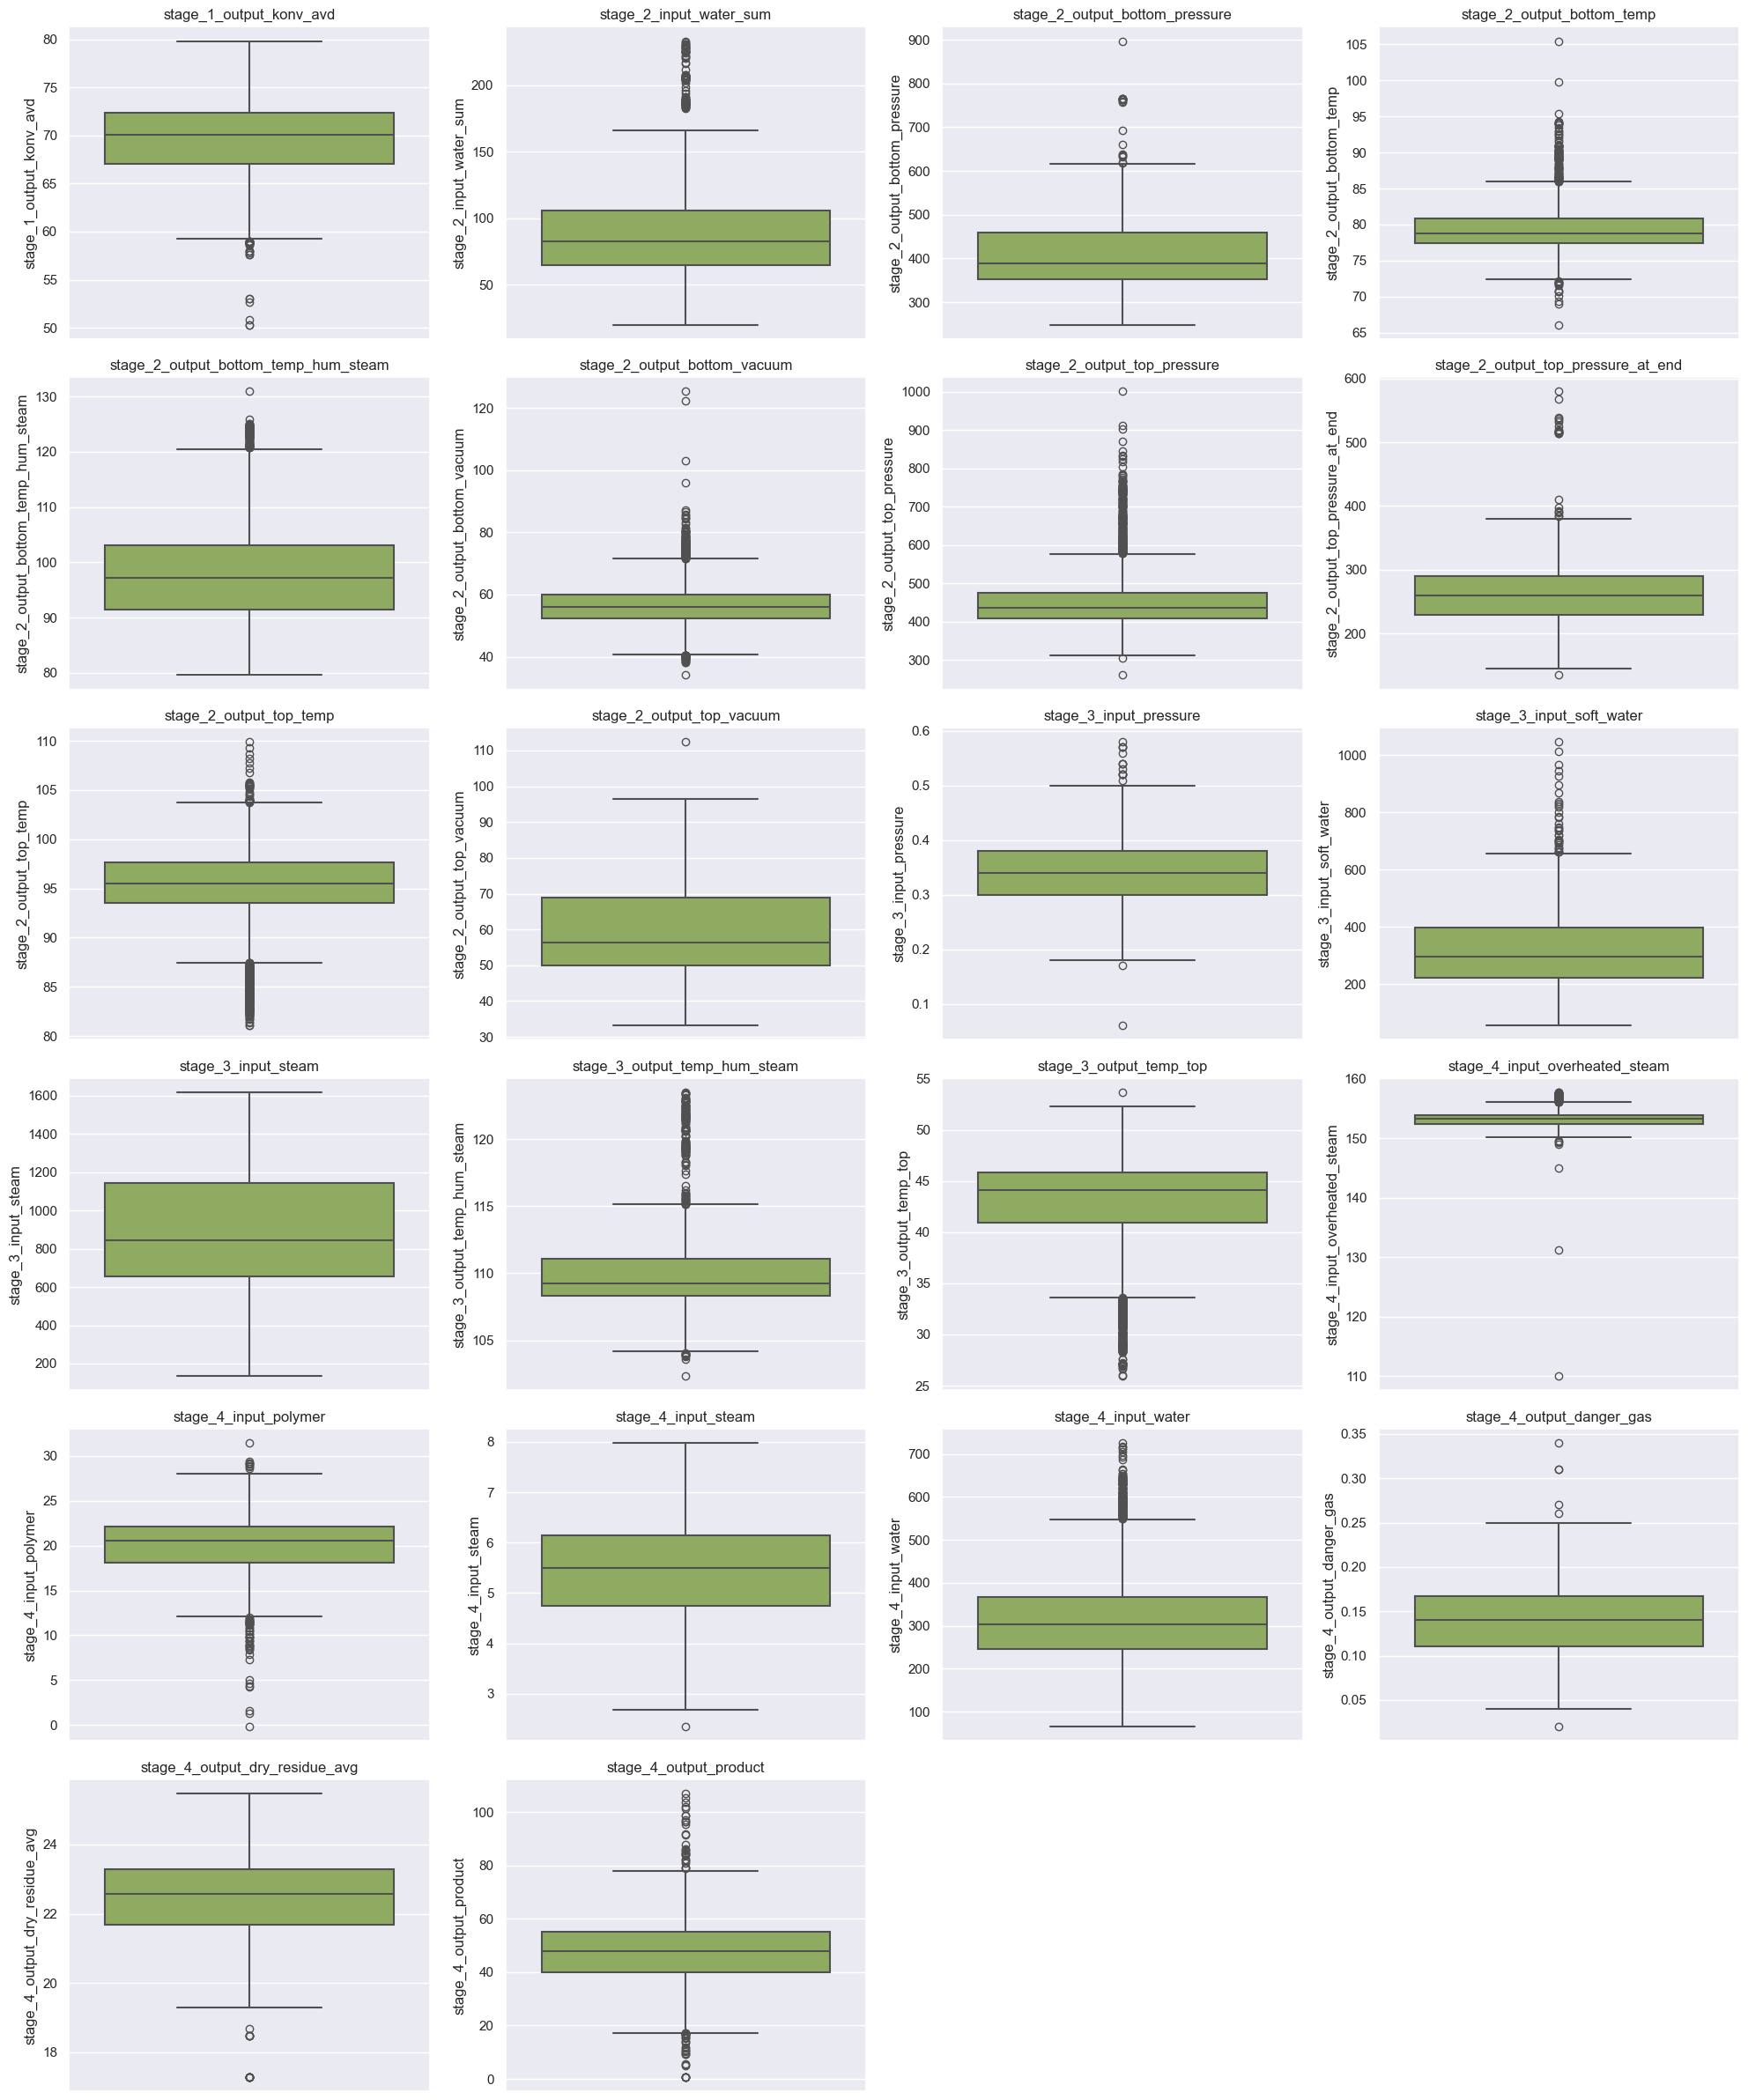

In [158]:
excluded_columns = ['datetime', 'work_shift']
columns_to_plot = [col for col in df.columns if col not in excluded_columns]


num_plots = len(columns_to_plot)
cols = 4
rows = math.ceil(num_plots / cols)
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(y=df[col], color=color_for_histplot, linewidth=1.5)
    plt.title(col)
    plt.tight_layout()

plt.show()

Отдельно стоит посмотреть процессы аномально низких и аномально высоких значений danger_gas, т.к это может помочь решить поставленную задачу

In [159]:
df[df['stage_4_output_danger_gas'] > 0.25]

datetime  stage_1_output_konv_avd  stage_2_input_water_sum  \
690  2021-03-28 20:00:00                    67.83                    77.39   
842  2021-04-13 20:00:00                    69.03                   109.28   
876  2021-04-15 09:00:00                    67.83                   186.46   
2194 2022-02-01 12:00:00                    73.03                   113.16   
2215 2022-02-02 09:00:00                    74.23                   115.33   

      stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
690                           353.02                       77.52   
842                           485.49                       76.73   
876                           358.52                       78.07   
2194                          344.03                       77.63   
2215                          347.43                       77.83   

      stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
690                                 104.40                         57.09   
842                                  99.68                         55.48   
876                                  90.06                         58.78   
2194                                115.46                         53.94   
2215                                107.44                         57.02   

      stage_2_output_top_pressure  stage_2_output_top_pressure_at_end  \
690                        433.15                              314.94   
842                        330.14                              515.07   
876                        375.67                              267.27   
2194                       411.55                              227.46   
2215                       412.74                              257.30   

      stage_2_output_top_temp  ...  stage_3_output_temp_hum_steam  \
690                     94.78  ...                         110.52   
842                     99.97  ...                         110.89   
876                     98.37  ...                         111.42   
2194                    95.12  ...                         109.23   
2215                    92.90  ...                         108.33   

      stage_3_output_temp_top  stage_4_input_overheated_steam  \
690                     37.73                          155.15   
842                     47.04                          154.70   
876                     42.27                          154.79   
2194                    42.29                          153.51   
2215                    44.79                          153.55   

      stage_4_input_polymer  stage_4_input_steam  stage_4_input_water  \
690                   20.95                 3.66               311.93   
842                   18.11                 6.24               349.29   
876                   20.54                 7.09               413.72   
2194                  25.16                 7.32               306.01   
2215                  19.73                 6.04               255.95   

      stage_4_output_danger_gas  stage_4_output_dry_residue_avg  \
690                        0.31                           21.68   
842                        0.26                           23.68   
876                        0.31                           23.48   
2194                       0.27                           21.28   
2215                       0.34                           22.28   

      stage_4_output_product  work_shift  
690                    59.08         2.0  
842                    54.78         2.0  
876                    60.74         1.0  
2194                   52.79         1.0  
2215                   49.20         1.0  

[5 rows x 24 columns]

Все относятся к разным процессам производства полимера, исследуем их позже. (id=690, id=842, id=876, id=876, id=2194, id=2215)

In [160]:
df[df['stage_4_output_danger_gas'] < 0.05]

datetime  stage_1_output_konv_avd  stage_2_input_water_sum  \
545  2021-03-17 13:00:00                    69.73                   123.44   
1443 2021-12-02 21:00:00                    69.33                    81.44   
1529 2021-12-06 21:00:00                    70.63                    80.59   
3459 2022-06-29 08:00:00                    60.63                    66.45   
3890 2022-08-03 20:00:00                    58.83                    51.28   

      stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
545                           471.62                       79.52   
1443                          335.17                       76.88   
1529                          344.72                       77.07   
3459                          382.12                       78.60   
3890                          386.35                       80.61   

      stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
545                                 112.51                         59.19   
1443                                111.69                         52.72   
1529                                103.36                         55.28   
3459                                 87.30                         63.14   
3890                                 94.86                         51.47   

      stage_2_output_top_pressure  stage_2_output_top_pressure_at_end  \
545                        430.65                              311.34   
1443                       409.35                              224.87   
1529                       426.16                              255.73   
3459                       531.40                              328.39   
3890                       456.96                              211.57   

      stage_2_output_top_temp  ...  stage_3_output_temp_hum_steam  \
545                     95.64  ...                         110.99   
1443                    95.57  ...                         108.20   
1529                    92.88  ...                         108.97   
3459                    94.77  ...                         110.24   
3890                    90.59  ...                         109.53   

      stage_3_output_temp_top  stage_4_input_overheated_steam  \
545                     38.35                          156.69   
1443                    45.70                          153.30   
1529                    46.56                          153.07   
3459                    42.59                          151.53   
3890                    33.14                          151.98   

      stage_4_input_polymer  stage_4_input_steam  stage_4_input_water  \
545                   23.60                 5.24               239.12   
1443                  12.81                 5.95               327.66   
1529                  20.81                 5.55               291.06   
3459                  15.74                 3.05                84.42   
3890                  17.50                 3.27               217.99   

      stage_4_output_danger_gas  stage_4_output_dry_residue_avg  \
545                        0.04                           22.58   
1443                       0.04                           22.28   
1529                       0.04                           21.98   
3459                       0.04                           21.98   
3890                       0.02                           20.18   

      stage_4_output_product  work_shift  
545                    68.85         2.0  
1443                   27.83         2.0  
1529                   47.85         2.0  
3459                   47.83         1.0  
3890                   25.06         2.0  

[5 rows x 24 columns]

Все относятся к разным процессам производства полимера, исследуем их позже.  (id=545, id=1443, id=1529, id=3459, id=3890)

При анализе на адекватность данных сомнения вызывают выбросы:  
* stage_2_output_bottom_pressure > 800 т.к хоть и является почти вакумом, но является аномальным
* stage_2_output_bottom_temp_hum_steam > 130, теоретически давление связано с температурой, тогда выброс в stage_2_output_bottom_temp_hum_steam может быть связан с данным выбросом
* stage_2_output_bottom_vacuum > 90, дальше данные уже не совсем вакуум, а так называемый 'грубый вакуум', т.е уже идет нарушение процесса
* stage_2_output_top_pressure > 800, уже значительно 'грубый вакуум', можно предположить что есть определенная зависимость со всемы предыдущими 'аномалии' 
* stage_2_output_top_pressure_at_end > 500, сомнительная группа дальше 500, возможно произошло некое нарушение. Т.к кол во выбросов велико, а различия этих 2 групп слишком различно.  
* stage_2_output_top_vacuum > 110, очередная аномалия, вероятно опять связанная с 'одиночными аномалиями' прошлых входных данных
* stage_3_input_pressure < 0.1, значение давления очень близкое к вакууму. Это аномально малое значение.
* stage_4_input_overheated_steam < 147, можно увидеть большой разброс выбросов. Возможно нарушения тех.процесса
  
Проверим их, такие аномальные значения могут влиять на danger_gas, в случае если нет таргета (данных по газу) - удалим

In [161]:
df[df['stage_2_output_bottom_pressure'] > 800]

datetime  stage_1_output_konv_avd  stage_2_input_water_sum  \
3432 2022-06-19 04:00:00                    67.33                    61.36   

      stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
3432                          897.29                      105.46   

      stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
3432                                105.31                         73.73   

      stage_2_output_top_pressure  stage_2_output_top_pressure_at_end  \
3432                       830.38                              301.13   

      stage_2_output_top_temp  ...  stage_3_output_temp_hum_steam  \
3432                   106.78  ...                         108.33   

      stage_3_output_temp_top  stage_4_input_overheated_steam  \
3432                    44.92                          152.95   

      stage_4_input_polymer  stage_4_input_steam  stage_4_input_water  \
3432                  13.72                 5.47                305.4   

      stage_4_output_danger_gas  stage_4_output_dry_residue_avg  \
3432                        NaN                           22.98   

      stage_4_output_product  work_shift  
3432                   34.19         1.0  

[1 rows x 24 columns]

В этом выбросе Nan в danger_gas, поэтому по сути не имеет смысла для нас, т.к не поможет в решении задачи, поэтому во всем следующем анализе выбросов оставим только те, где danger_gas не пустой.

In [162]:
df[(df['stage_2_output_bottom_temp_hum_steam'] > 130) & (df['stage_4_output_danger_gas'].notna())]

Empty DataFrame
Columns: [datetime, stage_1_output_konv_avd, stage_2_input_water_sum, stage_2_output_bottom_pressure, stage_2_output_bottom_temp, stage_2_output_bottom_temp_hum_steam, stage_2_output_bottom_vacuum, stage_2_output_top_pressure, stage_2_output_top_pressure_at_end, stage_2_output_top_temp, stage_2_output_top_vacuum, stage_3_input_pressure, stage_3_input_soft_water, stage_3_input_steam, stage_3_output_temp_hum_steam, stage_3_output_temp_top, stage_4_input_overheated_steam, stage_4_input_polymer, stage_4_input_steam, stage_4_input_water, stage_4_output_danger_gas, stage_4_output_dry_residue_avg, stage_4_output_product, work_shift]
Index: []

[0 rows x 24 columns]

Пусто. Тут нет ничего интересного нам


In [163]:
df[(df['stage_2_output_bottom_vacuum'] > 90) & (df['stage_4_output_danger_gas'].notna())]

datetime  stage_1_output_konv_avd  stage_2_input_water_sum  \
473 2021-03-02 13:00:00                    74.93                   114.79   

     stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
473                          660.03                       92.55   

     stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
473                                 98.14                        122.38   

     stage_2_output_top_pressure  stage_2_output_top_pressure_at_end  \
473                       767.24                              263.23   

     stage_2_output_top_temp  ...  stage_3_output_temp_hum_steam  \
473                    99.31  ...                         107.91   

     stage_3_output_temp_top  stage_4_input_overheated_steam  \
473                    49.24                          156.92   

     stage_4_input_polymer  stage_4_input_steam  stage_4_input_water  \
473                   4.25                 6.58               437.19   

     stage_4_output_danger_gas  stage_4_output_dry_residue_avg  \
473                       0.12                           22.18   

     stage_4_output_product  work_shift  
473                   57.85         1.0  

[1 rows x 24 columns]

stage_2_ouput_bottom_vacuum(id=473) измерили danger_gas, стоит проанализировать его остальные величины и возможно конкретно этот процесс производства полимера в целом. Хоть и значение danger_gas не является выбросом

In [164]:
df[(df['stage_2_output_top_pressure'] > 800) & (df['stage_4_output_danger_gas'].notna())]

datetime  stage_1_output_konv_avd  stage_2_input_water_sum  \
4173 2022-09-28 08:00:00                    64.33                    86.92   
4174 2022-09-28 20:00:00                    67.83                    87.08   
4398 2023-03-21 01:00:00                    70.03                    62.80   
4399 2023-03-21 12:00:00                    66.83                    50.97   

      stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
4173                          473.35                       85.58   
4174                          475.01                       85.32   
4398                          378.37                       79.16   
4399                          370.93                       78.71   

      stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
4173                                103.00                         56.12   
4174                                104.29                         57.19   
4398                                110.50                         63.16   
4399                                111.51                         60.06   

      stage_2_output_top_pressure  stage_2_output_top_pressure_at_end  \
4173                       833.47                              303.10   
4174                       903.16                              328.27   
4398                       845.66                              223.15   
4399                      1000.75                              206.75   

      stage_2_output_top_temp  ...  stage_3_output_temp_hum_steam  \
4173                   103.09  ...                         105.71   
4174                   104.79  ...                         106.15   
4398                   103.01  ...                         108.18   
4399                   103.86  ...                         110.13   

      stage_3_output_temp_top  stage_4_input_overheated_steam  \
4173                    47.44                          151.97   
4174                    45.16                          151.94   
4398                    47.70                          151.80   
4399                    43.42                          153.01   

      stage_4_input_polymer  stage_4_input_steam  stage_4_input_water  \
4173                  21.21                 5.22               544.26   
4174                  21.17                 5.09               538.23   
4398                  22.44                 3.66               460.04   
4399                  21.68                 3.35               481.95   

      stage_4_output_danger_gas  stage_4_output_dry_residue_avg  \
4173                       0.14                           21.38   
4174                       0.07                           21.58   
4398                       0.18                           22.38   
4399                       0.20                           22.18   

      stage_4_output_product  work_shift  
4173                   34.02         2.0  
4174                   34.07         2.0  
4398                   10.11         1.0  
4399                    9.59         1.0  

[4 rows x 24 columns]

имеем 4 значения(id=4173, id=4174, id=4398, id=4399), все они происходили в разные процессы, т.е вероятно не имееют связи между друг другом. Стоит заметить, что значения danger_gas довольно далеки от его медианного значения

In [165]:
df[(df['stage_2_output_top_pressure_at_end'] > 500) & (df['stage_4_output_danger_gas'].notna())]

datetime  stage_1_output_konv_avd  stage_2_input_water_sum  \
831  2021-04-13 09:00:00                    65.93                    98.04   
842  2021-04-13 20:00:00                    69.03                   109.28   
843  2021-04-13 21:00:00                    68.93                   112.35   
846  2021-04-14 00:00:00                    68.83                   112.05   
2641 2022-03-17 08:00:00                    75.63                    68.73   
2642 2022-03-17 21:00:00                    74.83                    69.46   

      stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
831                           478.73                       77.55   
842                           485.49                       76.73   
843                           484.42                       76.85   
846                           479.83                       76.36   
2641                          329.93                       77.42   
2642                          346.06                       78.30   

      stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
831                                  89.10                         59.36   
842                                  99.68                         55.48   
843                                 100.58                         55.64   
846                                 101.96                         54.66   
2641                                 85.40                         56.20   
2642                                 87.41                         59.53   

      stage_2_output_top_pressure  stage_2_output_top_pressure_at_end  \
831                        342.79                              534.62   
842                        330.14                              515.07   
843                        331.63                              516.68   
846                        324.01                              515.96   
2641                       362.93                              579.64   
2642                       375.73                              567.82   

      stage_2_output_top_temp  ...  stage_3_output_temp_hum_steam  \
831                     93.36  ...                         111.64   
842                     99.97  ...                         110.89   
843                    100.92  ...                         110.88   
846                    102.40  ...                         110.90   
2641                    94.79  ...                         109.12   
2642                    96.17  ...                         109.11   

      stage_3_output_temp_top  stage_4_input_overheated_steam  \
831                     46.99                          154.99   
842                     47.04                          154.70   
843                     46.50                          154.69   
846                     45.41                          154.81   
2641                    40.14                          153.53   
2642                    41.26                          153.57   

      stage_4_input_polymer  stage_4_input_steam  stage_4_input_water  \
831                   19.42                 6.22               367.54   
842                   18.11                 6.24               349.29   
843                   18.76                 6.23               325.82   
846                   17.92                 6.23               336.75   
2641                  18.31                 5.45               305.60   
2642                  18.45                 5.47                  NaN   

      stage_4_output_danger_gas  stage_4_output_dry_residue_avg  \
831                        0.14                           23.48   
842                        0.26                           23.68   
843                        0.11                           23.68   
846                        0.17                           23.68   
2641                       0.16                           24.08   
2642                       0.20                           24.48   

      stage_4_output_prod

Заметим, что некоторые из данных значений относятся к одну процессу производства полимера, а именно (id=831, id=842, id=846, id=846) и отдельно (id=2641, id=2642). При этом в некоторых процессах danger_gas довольно большой

In [166]:
df[(df['stage_2_output_top_vacuum'] > 110) & (df['stage_4_output_danger_gas'].notna())]

Empty DataFrame
Columns: [datetime, stage_1_output_konv_avd, stage_2_input_water_sum, stage_2_output_bottom_pressure, stage_2_output_bottom_temp, stage_2_output_bottom_temp_hum_steam, stage_2_output_bottom_vacuum, stage_2_output_top_pressure, stage_2_output_top_pressure_at_end, stage_2_output_top_temp, stage_2_output_top_vacuum, stage_3_input_pressure, stage_3_input_soft_water, stage_3_input_steam, stage_3_output_temp_hum_steam, stage_3_output_temp_top, stage_4_input_overheated_steam, stage_4_input_polymer, stage_4_input_steam, stage_4_input_water, stage_4_output_danger_gas, stage_4_output_dry_residue_avg, stage_4_output_product, work_shift]
Index: []

[0 rows x 24 columns]

Пусто...

In [167]:
df[(df['stage_3_input_pressure'] < 0.1) & (df['stage_4_output_danger_gas'].notna())]

Empty DataFrame
Columns: [datetime, stage_1_output_konv_avd, stage_2_input_water_sum, stage_2_output_bottom_pressure, stage_2_output_bottom_temp, stage_2_output_bottom_temp_hum_steam, stage_2_output_bottom_vacuum, stage_2_output_top_pressure, stage_2_output_top_pressure_at_end, stage_2_output_top_temp, stage_2_output_top_vacuum, stage_3_input_pressure, stage_3_input_soft_water, stage_3_input_steam, stage_3_output_temp_hum_steam, stage_3_output_temp_top, stage_4_input_overheated_steam, stage_4_input_polymer, stage_4_input_steam, stage_4_input_water, stage_4_output_danger_gas, stage_4_output_dry_residue_avg, stage_4_output_product, work_shift]
Index: []

[0 rows x 24 columns]

Пусто...

In [168]:
df[(df['stage_4_input_overheated_steam'] < 147) & (df['stage_4_output_danger_gas'].notna())]

datetime  stage_1_output_konv_avd  stage_2_input_water_sum  \
2290 2022-02-12 12:00:00                    71.83                    62.69   

      stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
2290                          334.45                       76.36   

      stage_2_output_bottom_temp_hum_steam  stage_2_output_bottom_vacuum  \
2290                                112.23                          51.6   

      stage_2_output_top_pressure  stage_2_output_top_pressure_at_end  \
2290                       427.14                              231.92   

      stage_2_output_top_temp  ...  stage_3_output_temp_hum_steam  \
2290                    94.34  ...                         109.32   

      stage_3_output_temp_top  stage_4_input_overheated_steam  \
2290                    42.24                          144.98   

      stage_4_input_polymer  stage_4_input_steam  stage_4_input_water  \
2290                  20.69                 4.45               138.25   

      stage_4_output_danger_gas  stage_4_output_dry_residue_avg  \
2290                       0.12                           22.08   

      stage_4_output_product  work_shift  
2290                   24.74         2.0  

[1 rows x 24 columns]

1 значение id=2290, danger_gas в норме

На графиках можно заметить, что в некоторых факторах можно пересмотреть контрольные границы т.к количество выбросов до определенного значения  настолько велико, что можно назвать данные значения характерными для этого процесса.

Обновим некоторые границы после которых начинаются странности в данных
* stage_1_output_konv_avd:                               нижняя граница - 57
* stage_2_input_water_sum:                               верхняя граница - 240
* stage_2_output_bottom_pressure:                        верхняя граница - 620  
* stage_2_output_bottom_temp:                            нижняя граница - 73 и верхняя граница - 94
* stage_2_output_bottom_temp_hum_steam:                  верхняя граница - 124
* stage_2_output_bottom_vacuum:                          нижняя граница - 38 и верхняя граница - 85  
* stage_2_output_top_pressure:                           верхняя граница - 800  
* stage_2_output_top_pressure_at_end:                    верхняя граница - 400 
* stage_2_output_top_temp:                               нижняя граница - 82 и верхняя граница - 108  
* stage_3_input_soft_water:                              верхняя граница - 810
* stage_3_output_temp_hum_steam:                         нижняя граница - 104 и верхняя граница -126
* stage_3_output_temp_top:                               нижняя граница - 26
* stage_4_input_overheated_steam:                        нижняя граница - 149 и верхняя граница - 157 
* stage_4_input_polymer:                                 нижняя граница - 7 и верхняя граница - 29  
* stage_4_input_water:                                   верхняя граница - 700    
* stage_4_output_product:                                нижняя граница - 10 и верхняя граница - 86


Разделим на слабые (3 iqr) и супер (6 iqr) выбросы.  
6 iqr - аномальные и активно влияют на опасный газ

In [169]:
for i in df.columns[1:]:
    curr_df = df[i].describe()

    H = curr_df.iloc[6] - curr_df.iloc[4]

    no_upper_light = curr_df.iloc[4] + H * 3
    no_lower_light = curr_df.iloc[6] - H * 3

    no_upper_hard = curr_df.iloc[4] + H * 6
    no_lower_hard = curr_df.iloc[6] - H * 6

    len_i = len(i)
    print(f'==={i}{(40 - len_i) * "="}')
    res_1 = df[((df[i] >= no_upper_hard) | (df[i] <= no_lower_hard))][i]
    if len(res_1) != 0:
        print(f'{len(res_1)} - кол.во СУПЕР выбросов')
    
    res_2 = df[(df[i] >= no_upper_light) | (df[i] <= no_lower_light)][i]
    if len(res_2) != 0: 
        print(f'{len(res_2)} - кол.во обычных выбросов')
    print(' ')

===stage_1_output_konv_avd=================
6 - кол.во обычных выбросов
 
===stage_2_input_water_sum=================
67 - кол.во обычных выбросов
 
===stage_2_output_bottom_pressure==========
12 - кол.во обычных выбросов
 
===stage_2_output_bottom_temp==============
2 - кол.во СУПЕР выбросов
80 - кол.во обычных выбросов
 
===stage_2_output_bottom_temp_hum_steam====
1 - кол.во обычных выбросов
 
===stage_2_output_bottom_vacuum============
3 - кол.во СУПЕР выбросов
68 - кол.во обычных выбросов
 
===stage_2_output_top_pressure=============
9 - кол.во СУПЕР выбросов
173 - кол.во обычных выбросов
 
===stage_2_output_top_pressure_at_end======
17 - кол.во обычных выбросов
 
===stage_2_output_top_temp=================
328 - кол.во обычных выбросов
 
===stage_2_output_top_vacuum===============
1 - кол.во обычных выбросов
 
===stage_3_input_pressure==================
9 - кол.во обычных выбросов
 
===stage_3_input_soft_water================
16 - кол.во обычных выбросов
 
===stage_3_input_steam==

По итогу нам нет смысла в аномально больших выбросах если в них нет danger_gas, поэтому просто избавимся от них

In [170]:
df = df[~(
    (
        (df['stage_2_output_bottom_pressure'] > 800) |
        (df['stage_2_output_bottom_temp_hum_steam'] > 130) |
        (df['stage_2_output_bottom_vacuum'] > 80) |
        (df['stage_2_output_top_pressure_at_end'] > 500) |
        (df['stage_2_output_top_vacuum'] > 80) |
        (df['stage_3_input_pressure'] < 0.1) |
        (df['stage_4_input_overheated_steam'] < 147) |
        (df['stage_4_input_polymer'] < 5) |
        (df['stage_4_output_dry_residue_avg'] < 19)
    ) & 
    (df['stage_4_output_danger_gas'].isna())
)]

###  Аналитический и графический анализ данных

Посмотрим на распределение данных

22 22


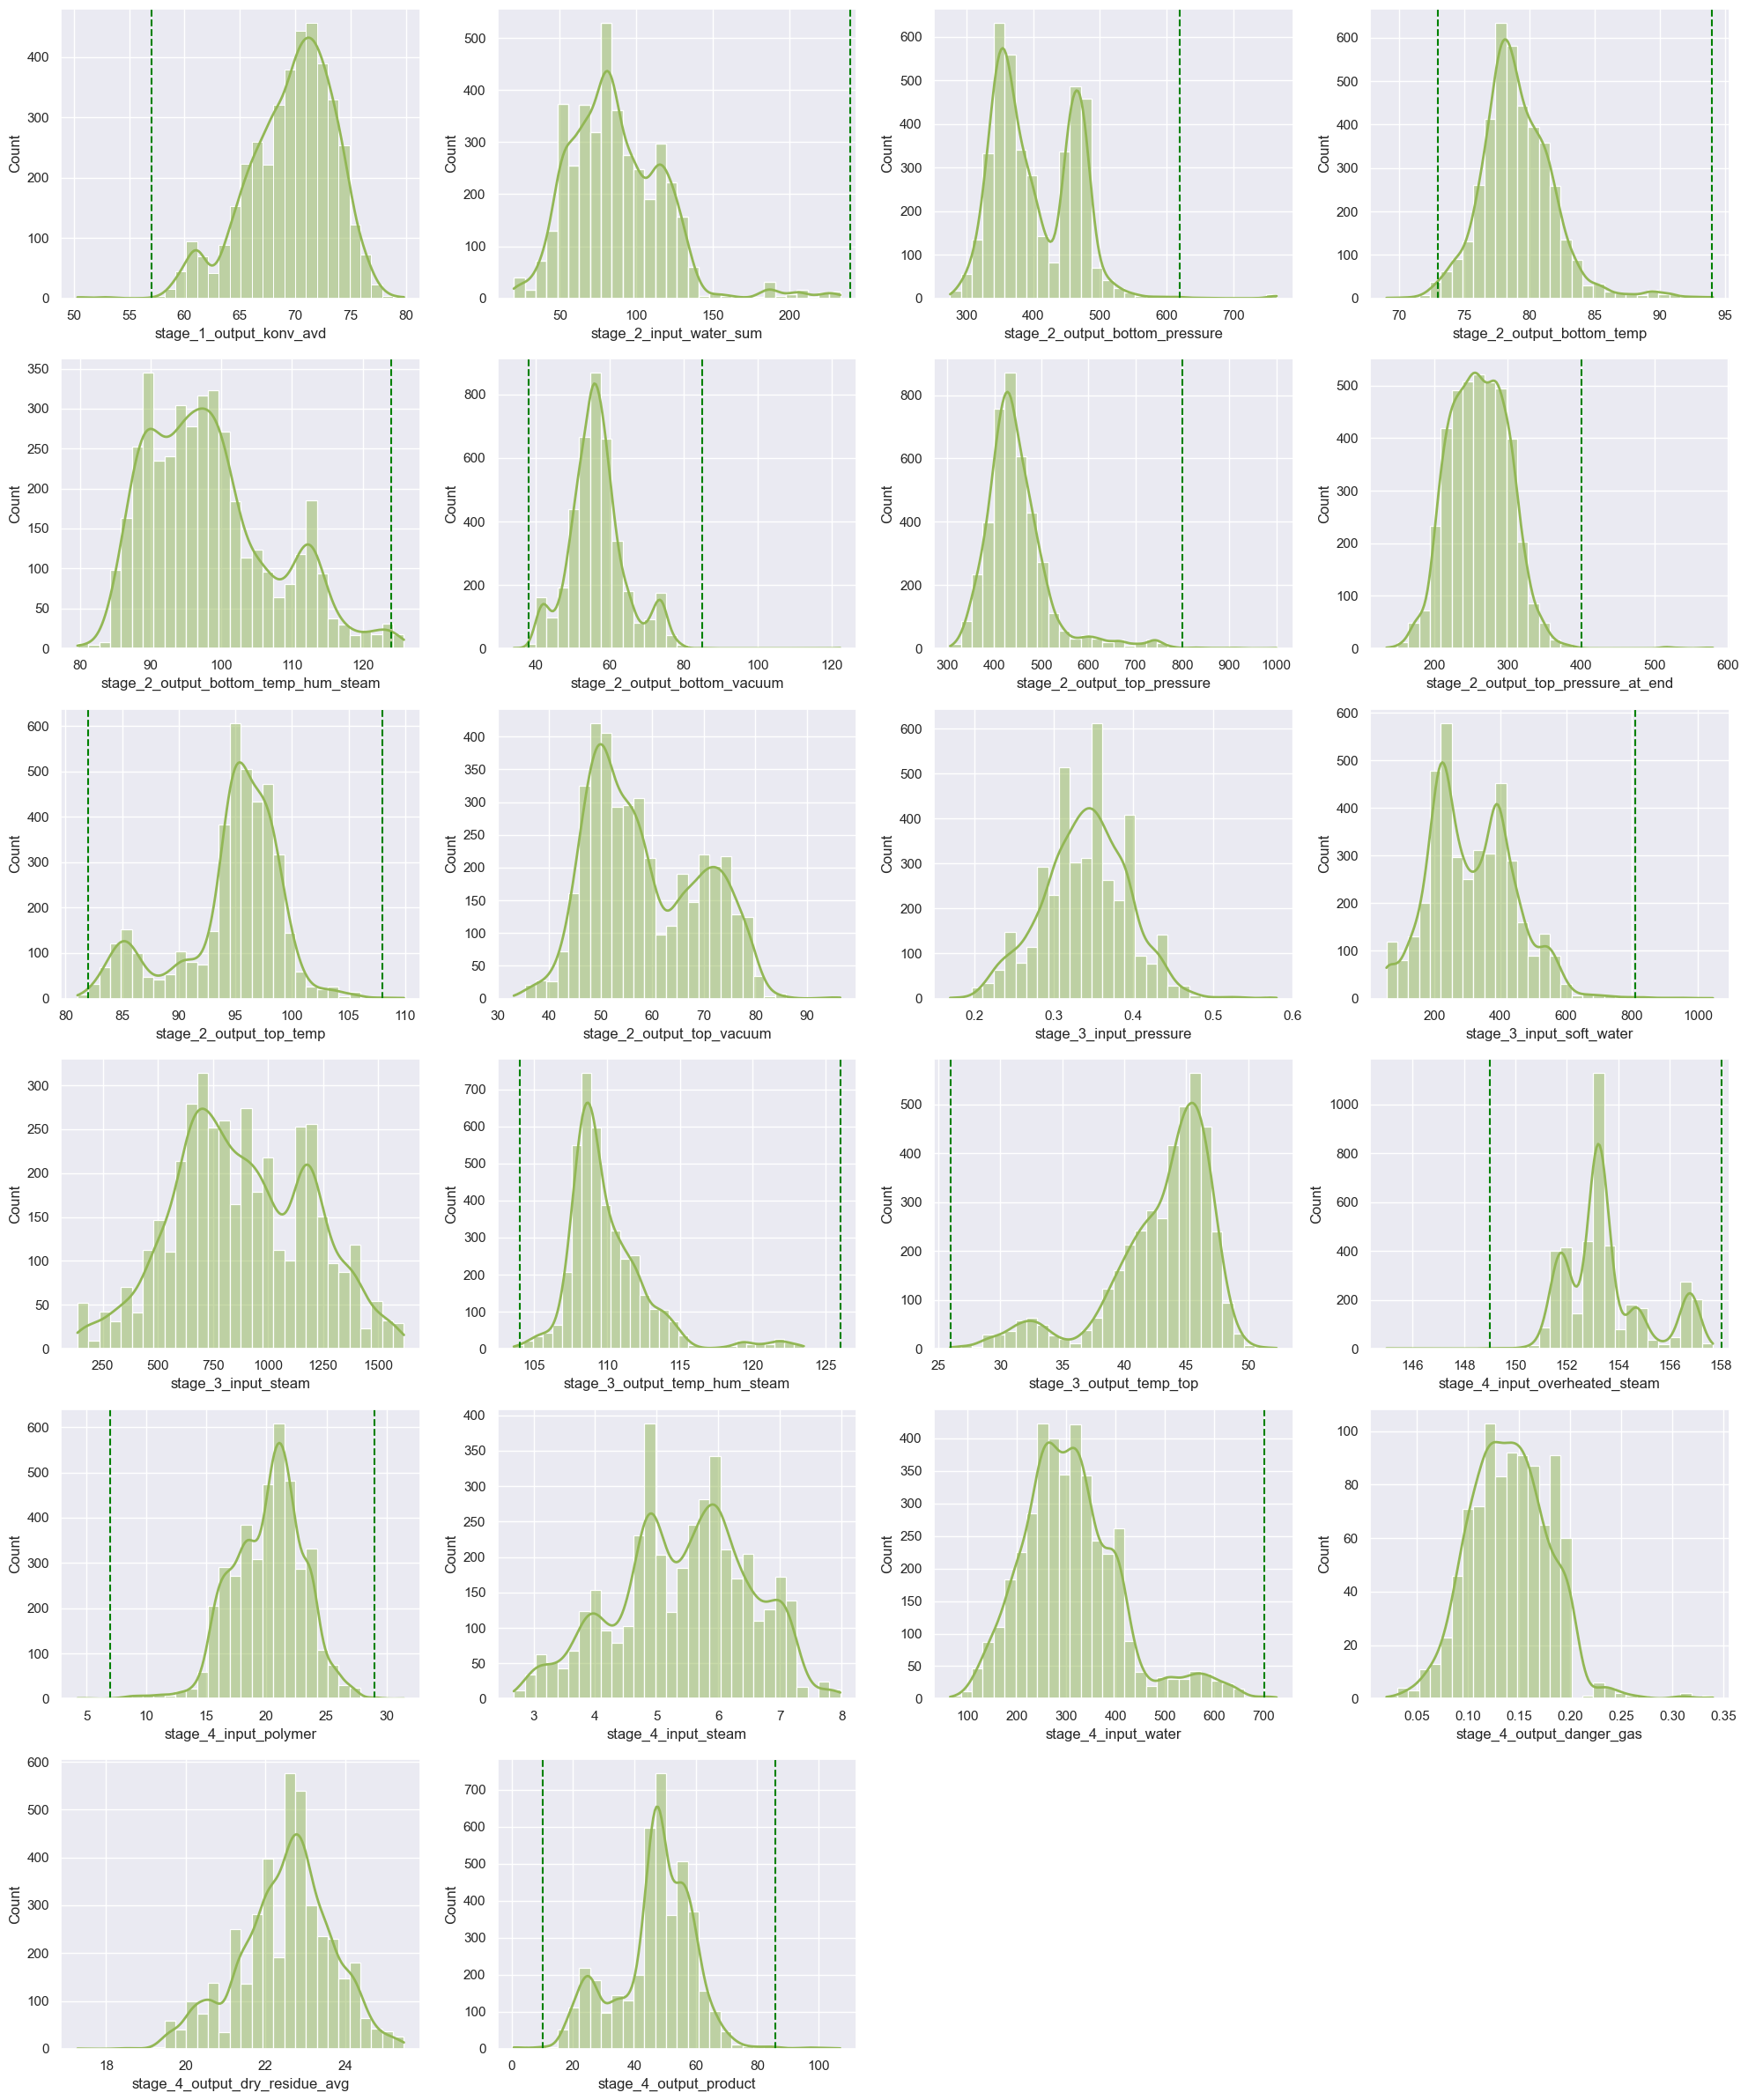

In [171]:
excluded_columns = ['datetime', 'work_shift']
columns_to_plot = [col for col in df.columns if col not in excluded_columns]


num_plots = len(columns_to_plot)
cols = 4
rows = math.ceil(num_plots / cols)

lines_vals = [57, 240, 620, [73, 94], 124, [38, 85], 800, 400, [82, 108], '', '', 810, '', [104, 126],
              26, [149, 158], [7, 29], '', 700, '', '', [10, 86]]



def bild_line(res):
    return plt.axvline(x=res, color='green', linestyle='--')

print(len(lines_vals), len(columns_to_plot))
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[col], kde=True, bins=30, color=color_for_histplot, line_kws=line)
    if lines_vals[i - 1] != '':
        if type(lines_vals[i - 1]) != type([]):
            bild_line(lines_vals[i - 1])
        else:
            for q in lines_vals[i - 1]:
                bild_line(q)
    plt.tight_layout()

plt.show()

Очевидно, что распределение большинства факторов не нормально, хотя можно посчитать за нормальным распределение факторов (т.к свойства нормального распределения будут сохранятся): 
* stage_2_output_bottom_temp
* stage_2_output_top_pressure
* stage_2_output_top_pressure_at_end
* stage_3_input_pressure
* stage_3_output_temp_hum_steam
* stage_3_output_temp_top
* stage_4_input_polymer
* stage_4_output_danger_gas
* stage_4_output_dry_residue_avg

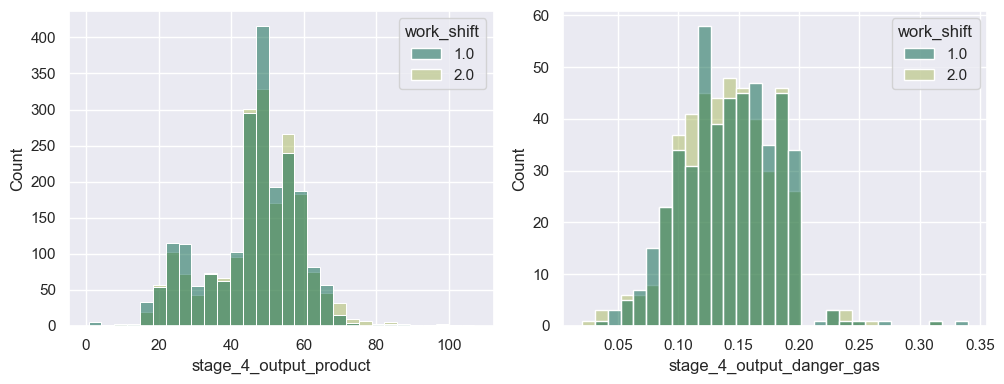

In [172]:
columns_to_plot = ['stage_4_output_product', 'stage_4_output_danger_gas']

num_plots = len(columns_to_plot)
cols = 4
rows = math.ceil(num_plots / cols)
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df, x=col, bins=30, color=color_for_histplot, line_kws=line, hue='work_shift', palette=for_hue_palette)
    plt.tight_layout()

plt.show()

На графиках можно заметить, что нет продукта и процента опасного газа от рабочей смены

Input + stage_4_output_product

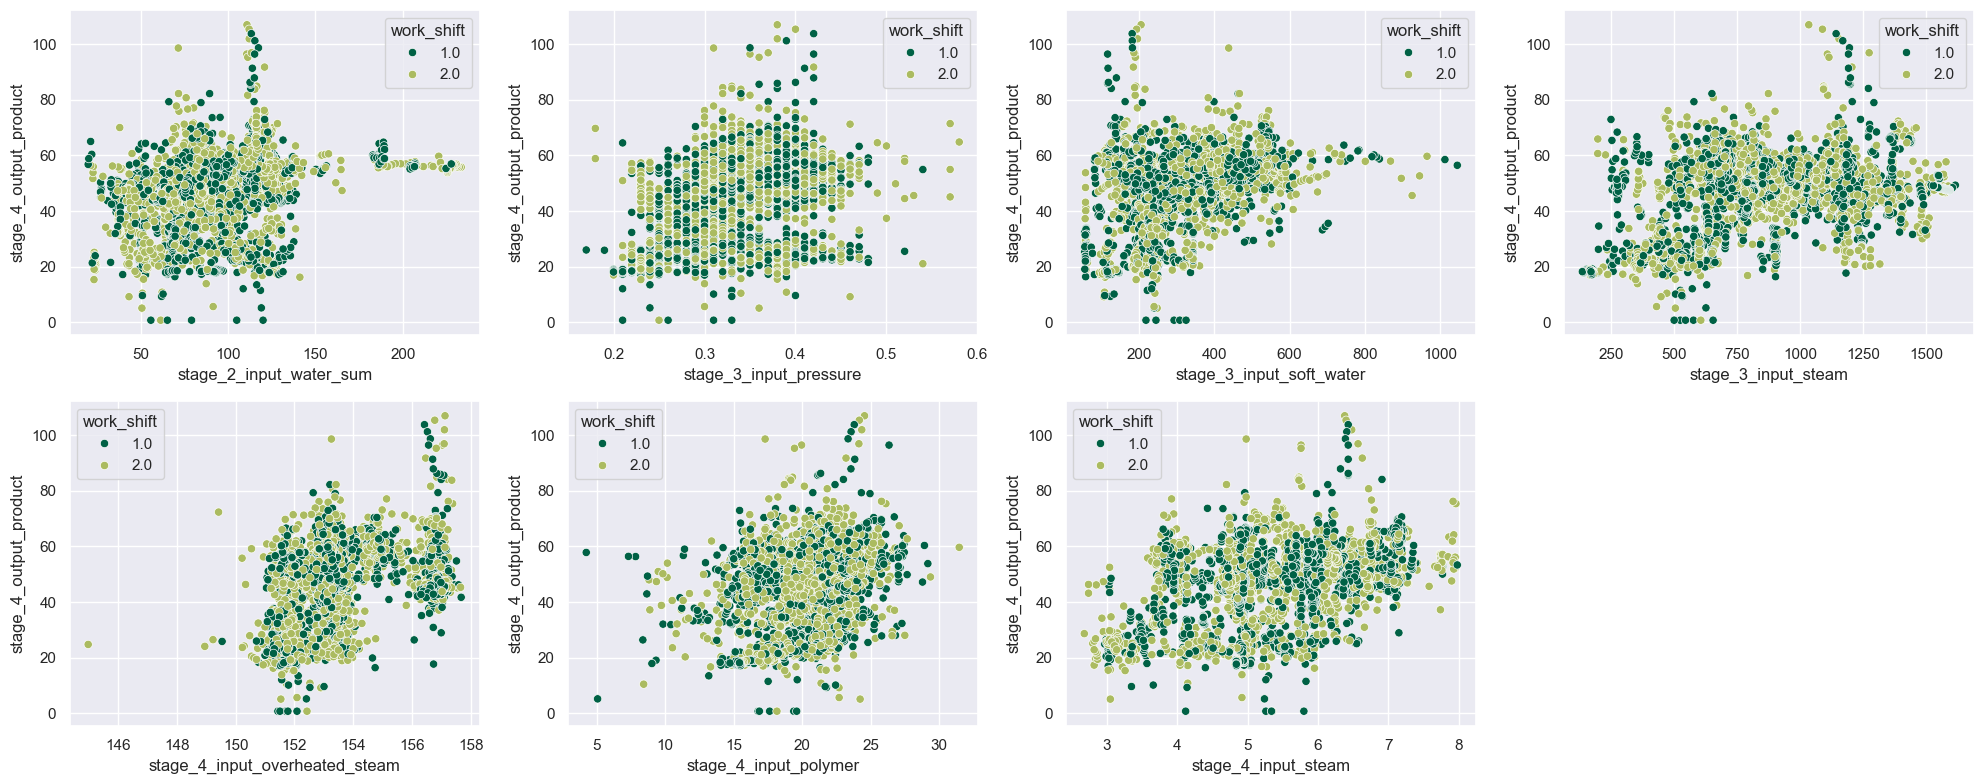

In [173]:
columns_to_plot = ['stage_2_input_water_sum', 'stage_3_input_pressure', 'stage_3_input_soft_water', 'stage_3_input_steam', 'stage_4_input_overheated_steam', 'stage_4_input_polymer', 'stage_4_input_steam']


num_plots = len(columns_to_plot)
cols = 4
rows = math.ceil(num_plots / cols)
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(rows, cols, i)
    sns.scatterplot(df, x=col, y='stage_4_output_product', color=color_for_histplot, hue='work_shift', palette=for_hue_palette)
    plt.tight_layout()

plt.show()

<!-- В общем случае тяжело заметить какую-либо сильную зависимость между входными параметрами и выходными показателями финального этапа, как и зависимости от рабочей смены, не просматривается. Отдельно можно выделить:

* stage_2_input_water_sum — плотное скопление точек за отметкой 170;
* stage_3_input_pressure — значения изменяются с одинаковым шагом, что нетипично для непрерывного процесса;
* stage_3_input_soft_water — все наблюдения выше 100, будто существует жёсткий нижний предел;
* stage_4_input_overheated_steam — ещё одно скопление, но уже после уровня 156 -->

На данном этапе мы не будем пытаться искать зависимость одной величины от другой, т.к это будет позже сделано в блоке с корреляционным анализом. Отметим примечательные своства этих графиков:
* У большинства графиков можно выделить кластер - похожие друг на друга значения, что нормально для процессов, которые поставлены 'на поток'
* Сильно выделяется то, что в графике с stage_3_input_pressure есть отдельные 'столбцы' (весь график распределен по столбцам) - это говорит нам о том, что изменение давления просиходит примерно на одну величину каждый такой 'столбец', что логично т.к давление настолько маленькое, что сложно дававть различные значение у этого фактора и не попадать в такой 'столбец'
* у stage_3_input_soft_water - значение stage_3_input_steam сильно разбросаны, очень сложно выделить конкретный кластер по ним
* то, что значение stage_4_input_overheated_steam 'прижаты' вправо нормально, т.к соответсвует раннее просмотренным boxsplot

Output + stage_4_output_product

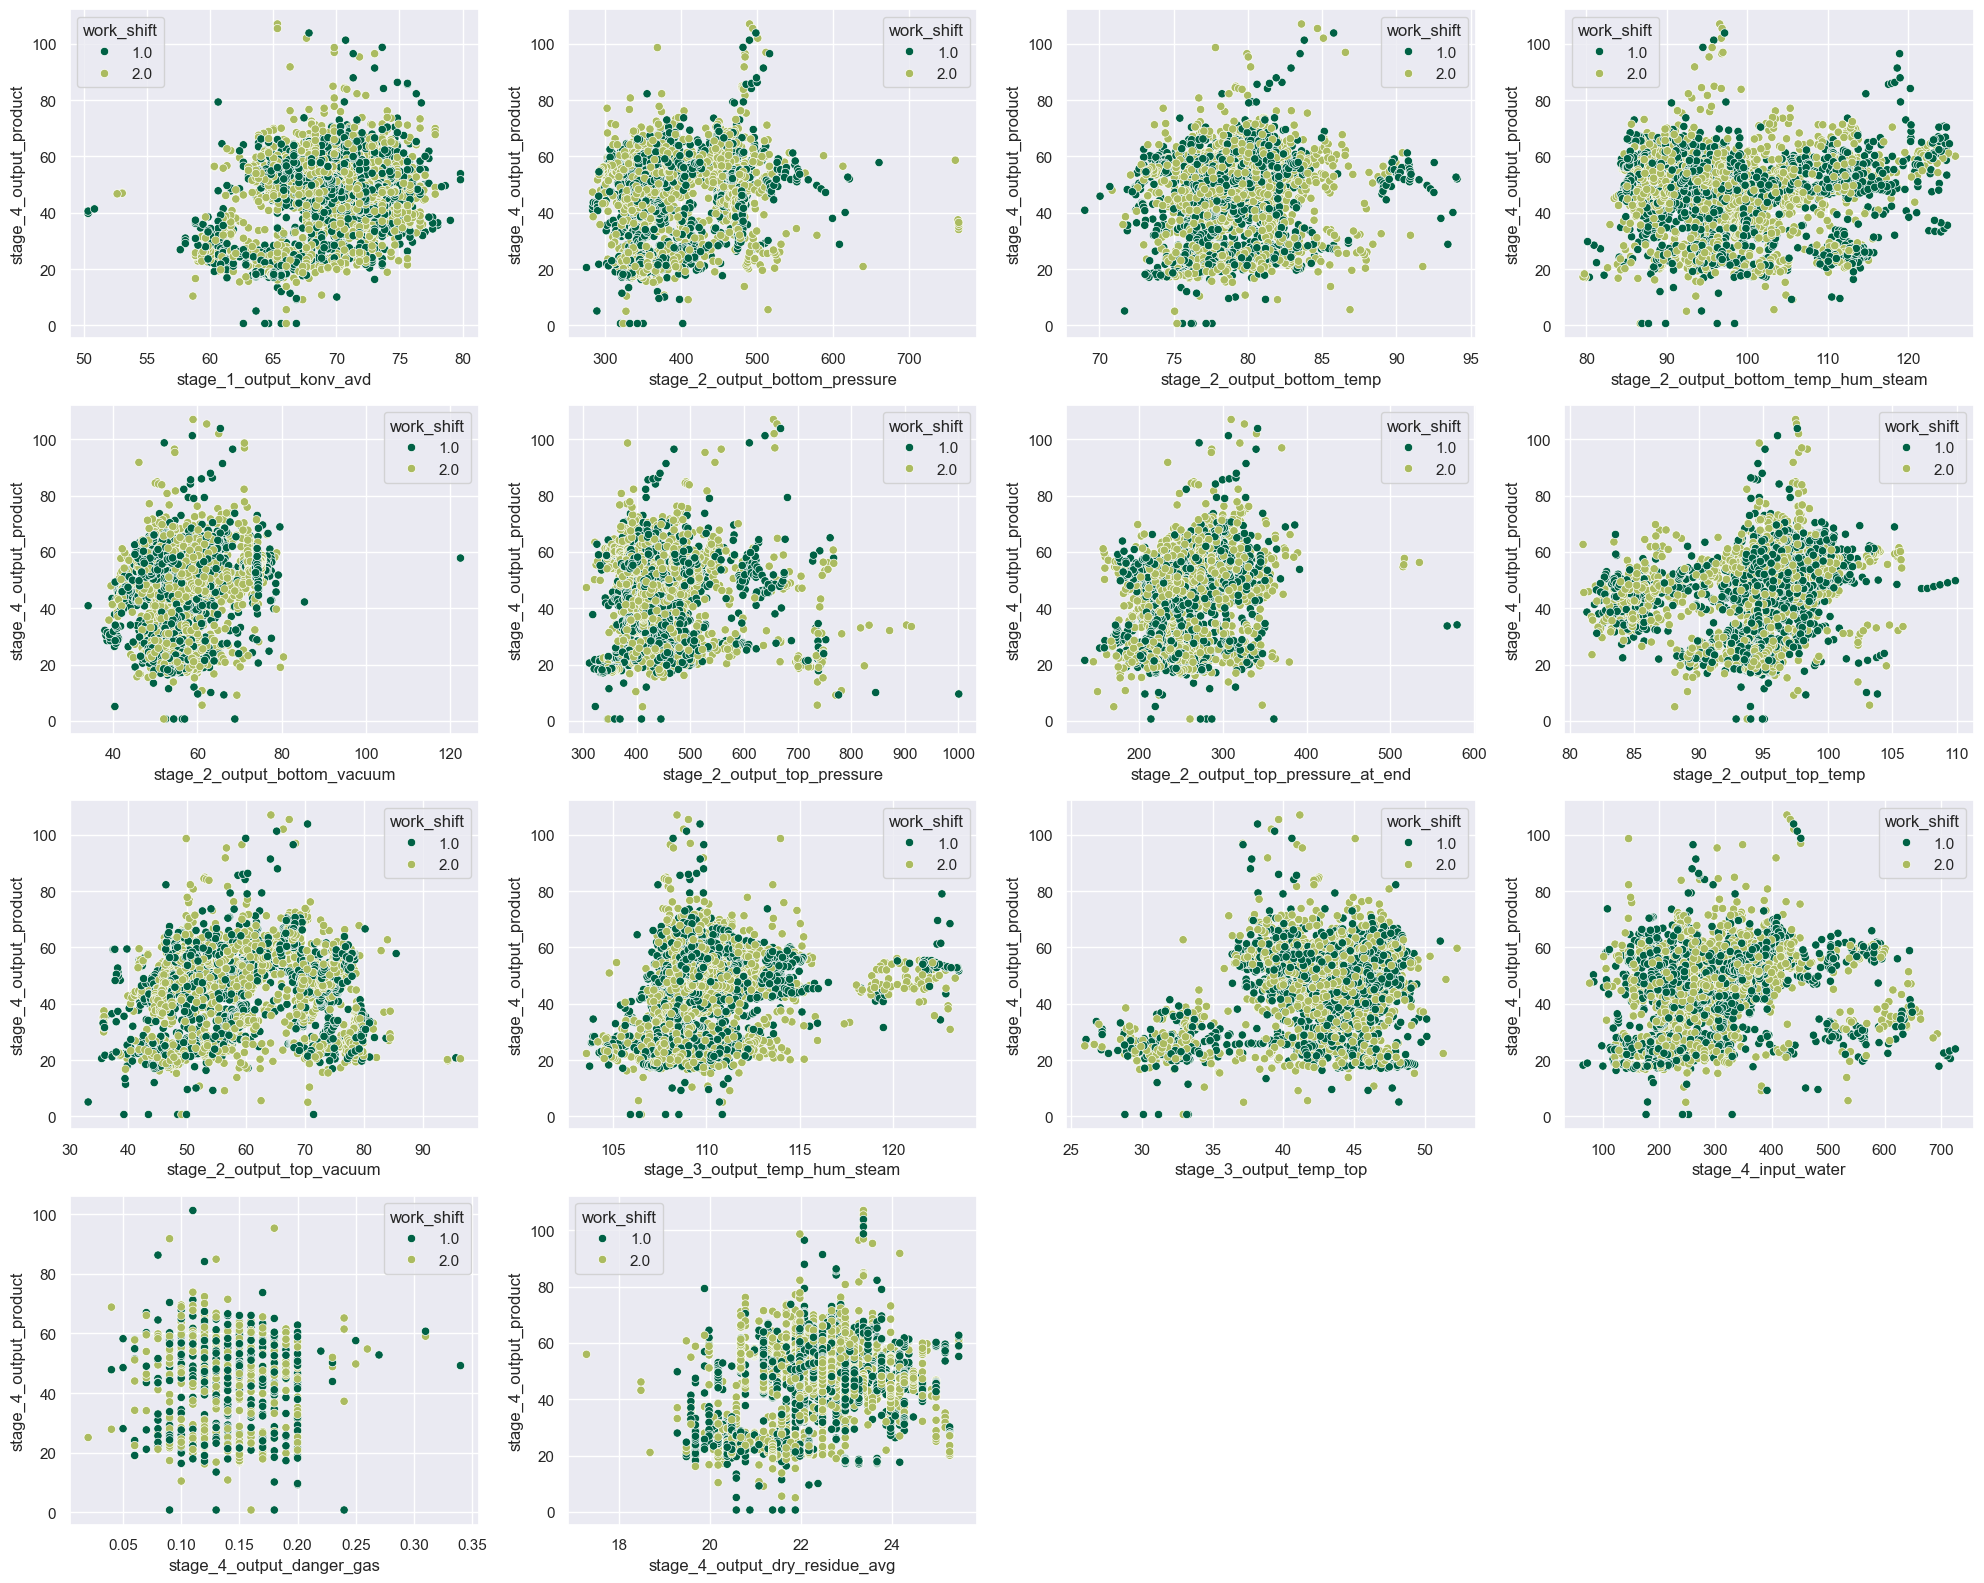

In [174]:
excluded_columns = ['datetime', 'stage_4_output_product', 'work_shift', 'stage_2_input_water_sum', 'stage_3_input_pressure', 'stage_3_input_soft_water', 'stage_3_input_steam', 'stage_4_input_overheated_steam', 'stage_4_input_polymer', 'stage_4_input_steam']
columns_to_plot = [col for col in df.columns if col not in excluded_columns]

num_plots = len(columns_to_plot)
cols = 4
rows = math.ceil(num_plots / cols)
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(rows, cols, i)
    sns.scatterplot(df, x=col, y='stage_4_output_product', color=color_for_histplot, hue='work_shift', palette=for_hue_palette)
    plt.tight_layout()

plt.show()

Выделим странности по этим графикам: 
* Stage_3_output_bottom_temp_hum_steam заметен странный мини-кластер с данными в основном из 2 смены.
* в Stage_2_output_top_temp кластер, отдельный от основного кластера данных;

Output + stage_4_output_danger_gas

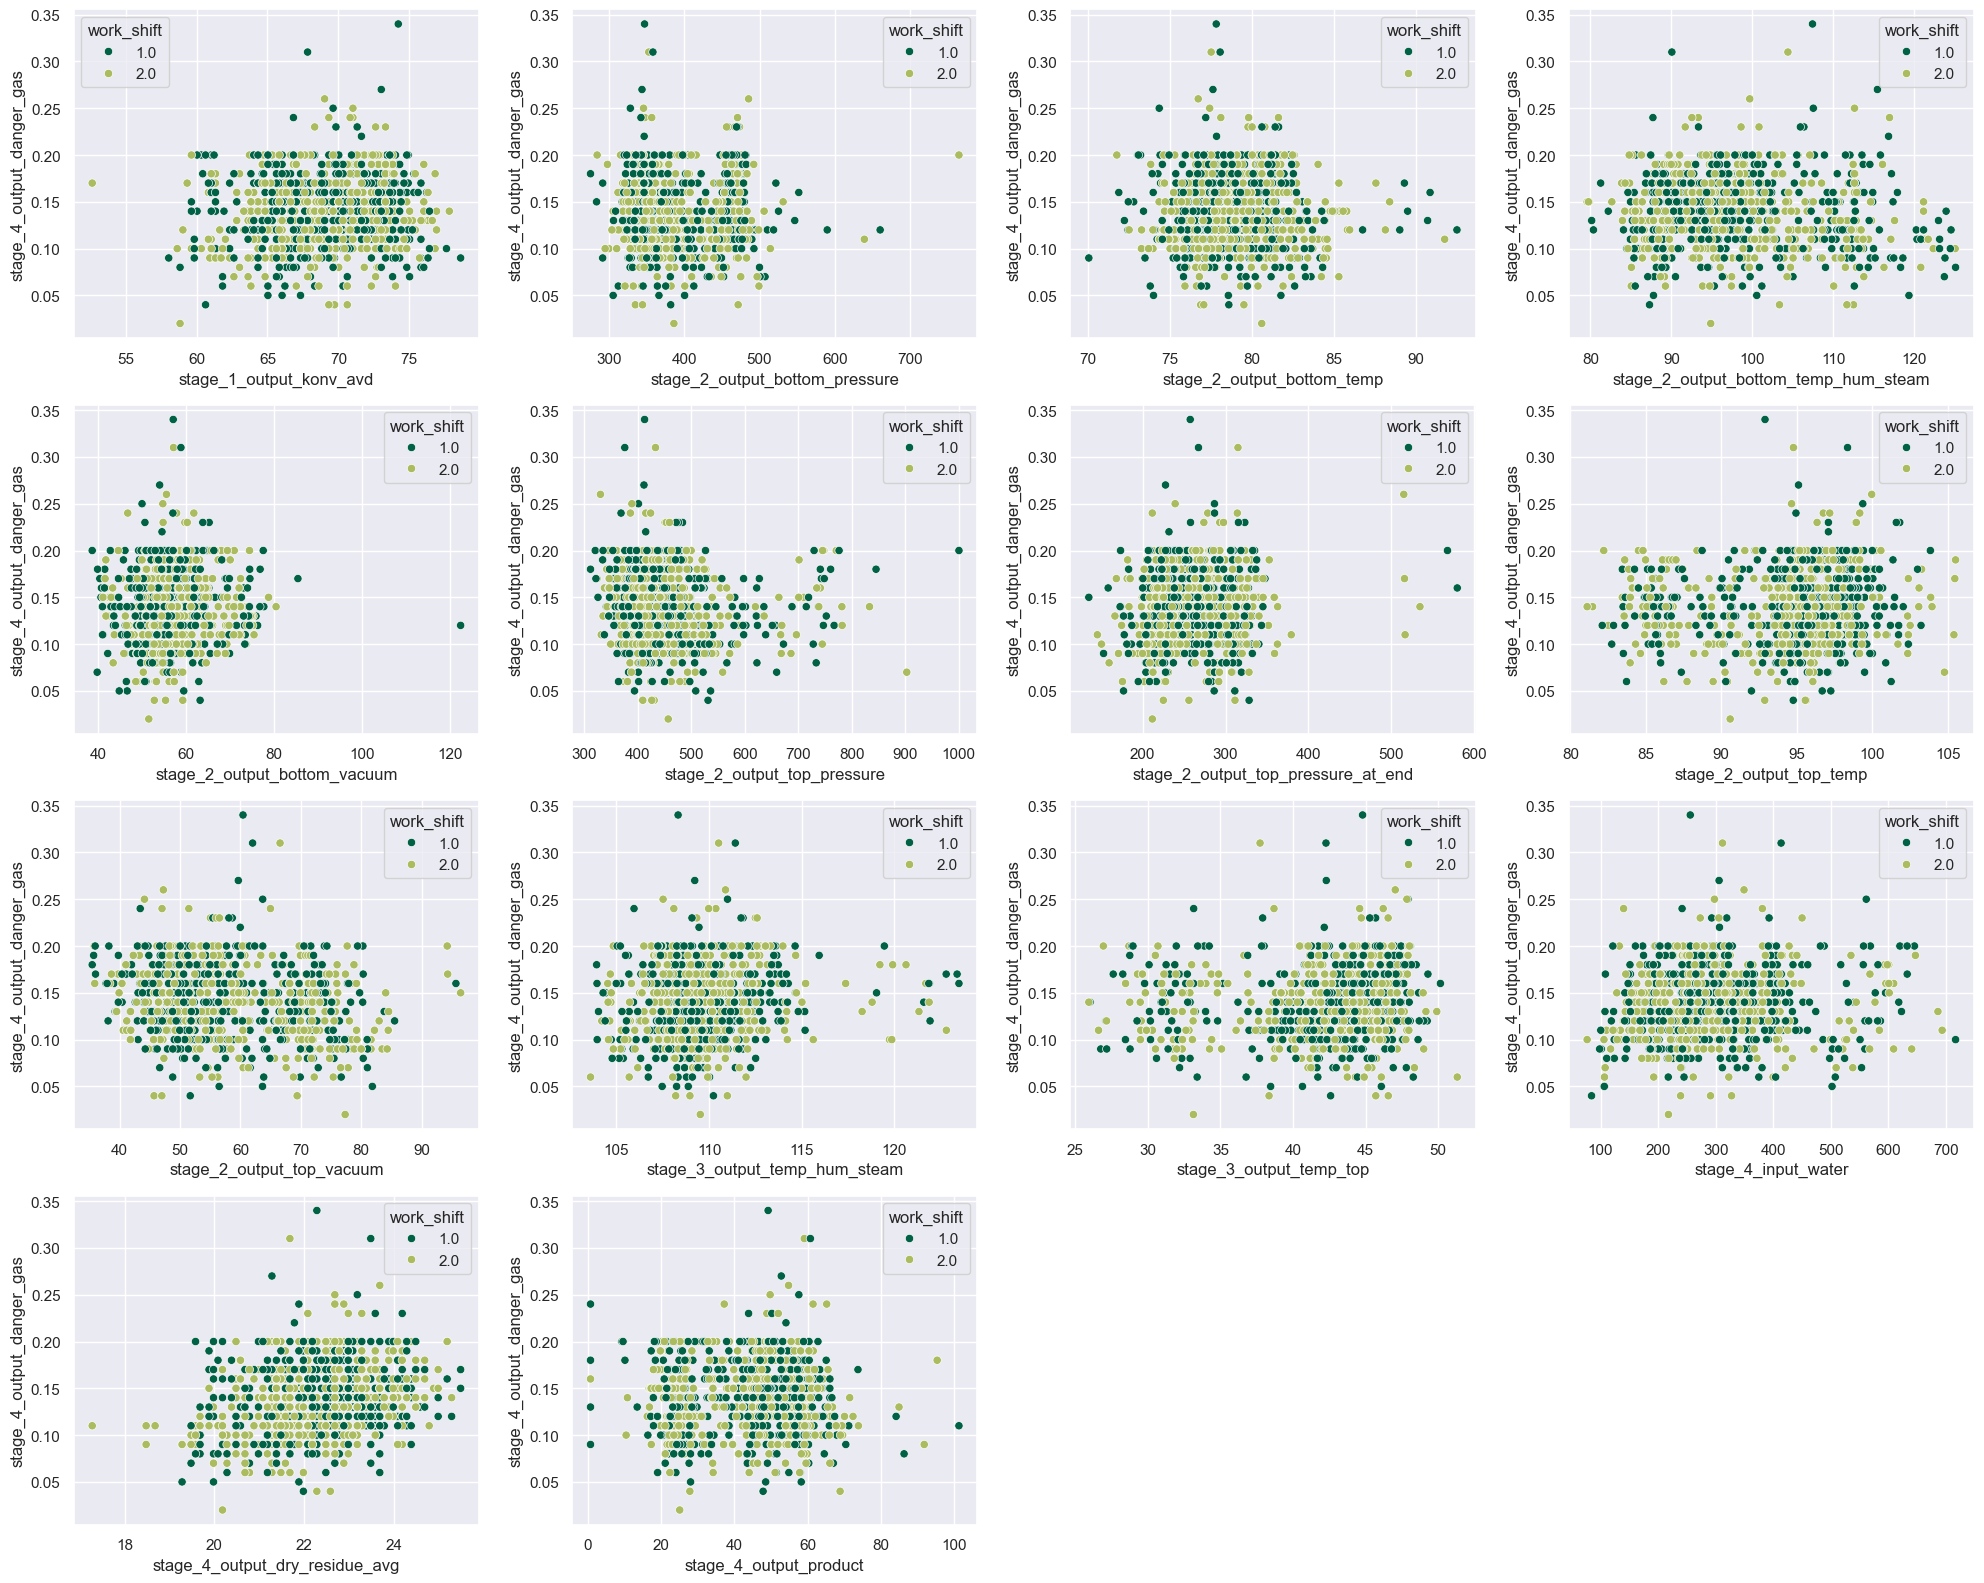

In [175]:
excluded_columns = ['datetime', 'stage_4_output_danger_gas', 'work_shift', 'stage_2_input_water_sum', 'stage_3_input_pressure', 'stage_3_input_soft_water', 'stage_3_input_steam', 'stage_4_input_overheated_steam', 'stage_4_input_polymer', 'stage_4_input_steam']
columns_to_plot = [col for col in df.columns if col not in excluded_columns]

num_plots = len(columns_to_plot)
cols = 4
rows = math.ceil(num_plots / cols)
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(rows, cols, i)
    sns.scatterplot(df, x=col, y='stage_4_output_danger_gas', color=color_for_histplot, hue='work_shift', palette=for_hue_palette)
    plt.tight_layout()

plt.show()

В этих графиках тяжело сделать какие либо выводы

Input + stage_4_output_danger_gas

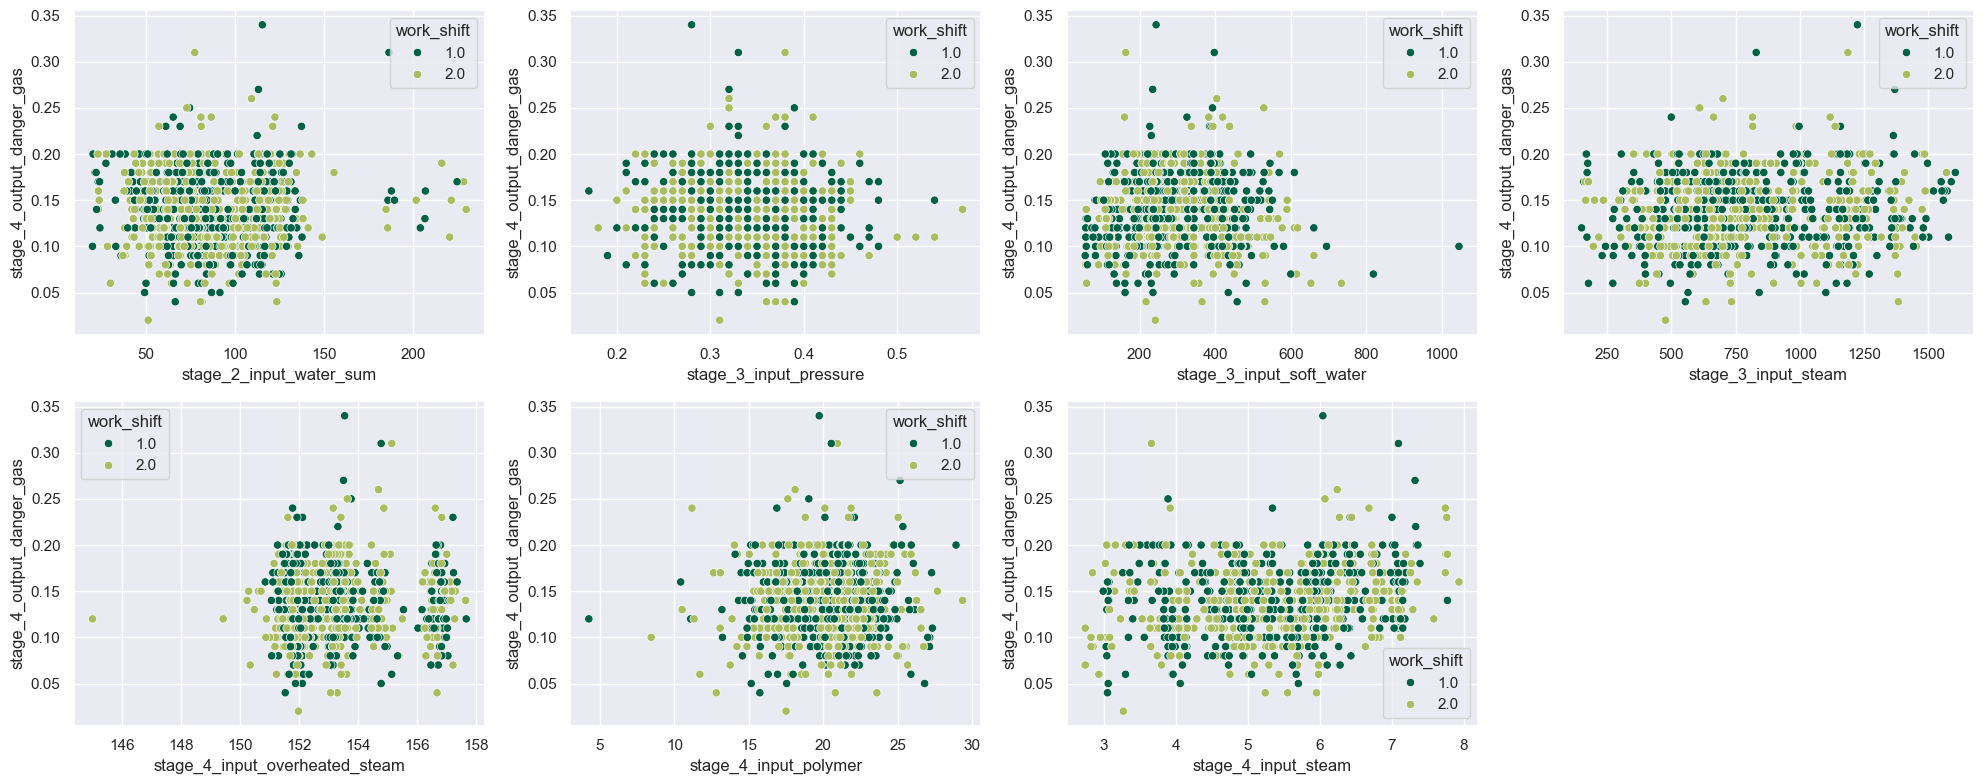

In [176]:
columns_to_plot = ['stage_2_input_water_sum', 'stage_3_input_pressure', 'stage_3_input_soft_water', 'stage_3_input_steam', 'stage_4_input_overheated_steam', 'stage_4_input_polymer', 'stage_4_input_steam']


num_plots = len(columns_to_plot)
cols = 4
rows = math.ceil(num_plots / cols)
plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(rows, cols, i)
    sns.scatterplot(df, x=col, y='stage_4_output_danger_gas', color=color_for_histplot, hue='work_shift', palette=for_hue_palette)
    plt.tight_layout()

plt.show()

Тяжело заметить какие либо аномалии

### Составим сводную таблицу по часам для смен, чтобы посмотреть как менялись смены у сотрудников

In [177]:
df_just_time = pd.DataFrame()
df_just_time['work_shift'] = df['work_shift']
df_just_time['time'] = df['datetime']
df_pivot_table = df_just_time.groupby('time')['work_shift'].value_counts()
df_just_time['work_shift'] = df['work_shift'].astype('int64')
df_pivot_table

time                 work_shift
2021-01-28 18:00:00  2.0           1
2021-01-28 19:00:00  2.0           1
2021-01-28 20:00:00  2.0           1
2021-01-28 21:00:00  2.0           1
2021-01-28 22:00:00  2.0           1
                                  ..
2023-03-19 12:00:00  2.0           1
2023-03-20 00:00:00  2.0           1
2023-03-20 12:00:00  1.0           1
2023-03-21 01:00:00  1.0           1
2023-03-21 12:00:00  1.0           1
Name: count, Length: 4092, dtype: int64

Видно, что по если смотерть по часам, то данные примерно одинаковы. Т.е смены идут не условно ночные/дневные, а чередуются как либо. Посмотрим в df как смены распределяются

In [178]:
df[['datetime', 'work_shift']].head(19)

datetime  work_shift
0  2021-01-28 18:00:00         2.0
1  2021-01-28 19:00:00         2.0
2  2021-01-28 20:00:00         2.0
3  2021-01-28 21:00:00         2.0
4  2021-01-28 22:00:00         2.0
5  2021-01-28 23:00:00         2.0
6  2021-01-29 00:00:00         2.0
7  2021-01-29 01:00:00         2.0
8  2021-01-29 02:00:00         2.0
9  2021-01-29 03:00:00         2.0
10 2021-01-29 04:00:00         2.0
11 2021-01-29 05:00:00         2.0
12 2021-01-29 06:00:00         2.0
13 2021-01-29 07:00:00         2.0
14 2021-01-29 08:00:00         1.0
15 2021-01-29 09:00:00         1.0
16 2021-01-29 10:00:00         1.0
17 2021-01-29 11:00:00         1.0
18 2021-01-29 12:00:00         1.0

Делаем очевидный вывод. Смены сменяют друг друга в 8 утра каждый день. Если наш процесс идет 12 часов, то за смену мы успеваем проконтролировать/пронаблюдать 2 процесса, тогда при заполнении пропусков логичнее будет использовать интерполяциюю (учитывая последние 12 часов конкретного процесса)

Теперь проанализируем все то, что отложили на стадии анализа выбросов

### Пропуски

In [179]:
df.isna().sum()

datetime                                   0
stage_1_output_konv_avd                   75
stage_2_input_water_sum                   61
stage_2_output_bottom_pressure            59
stage_2_output_bottom_temp                31
stage_2_output_bottom_temp_hum_steam      15
stage_2_output_bottom_vacuum              71
stage_2_output_top_pressure               20
stage_2_output_top_pressure_at_end        14
stage_2_output_top_temp                   44
stage_2_output_top_vacuum                 35
stage_3_input_pressure                    74
stage_3_input_soft_water                  51
stage_3_input_steam                       11
stage_3_output_temp_hum_steam             13
stage_3_output_temp_top                   67
stage_4_input_overheated_steam             9
stage_4_input_polymer                     66
stage_4_input_steam                       82
stage_4_input_water                       80
stage_4_output_danger_gas               3158
stage_4_output_dry_residue_avg             0
stage_4_ou

Посмотрим распределение всех данных, чтобы в целом оценить способы их замены.  
Т.к в случаех, если множество пропусков поряд стоит использовать либо среднее либо медиану.

In [180]:
def raspder(x):
    koalit = []
    for i in x.columns:
        _, res = shapiro(x[i])
        if res >= 0.05:
            koalit.append([i, 'нормальное'])
        else:
            koalit.append([i, 'ненормальное'])
    return pd.DataFrame(koalit, columns=['Параметр', 'Распределение'])
print(raspder(df.drop('datetime', axis=1)))

                                Параметр Распределение
0                stage_1_output_konv_avd  ненормальное
1                stage_2_input_water_sum  ненормальное
2         stage_2_output_bottom_pressure  ненормальное
3             stage_2_output_bottom_temp  ненормальное
4   stage_2_output_bottom_temp_hum_steam  ненормальное
5           stage_2_output_bottom_vacuum  ненормальное
6            stage_2_output_top_pressure  ненормальное
7     stage_2_output_top_pressure_at_end  ненормальное
8                stage_2_output_top_temp  ненормальное
9              stage_2_output_top_vacuum  ненормальное
10                stage_3_input_pressure  ненормальное
11              stage_3_input_soft_water  ненормальное
12                   stage_3_input_steam  ненормальное
13         stage_3_output_temp_hum_steam  ненормальное
14               stage_3_output_temp_top  ненормальное
15        stage_4_input_overheated_steam  ненормальное
16                 stage_4_input_polymer  ненормальное
17        

Из за смещения все распределения не нормальные, в целом лучше придерживаться первого варианта (с ручной проверкой).

Вывод: используем медиану если множество пропусков, в противном случаю интерполяцию за последние 12 часов.  
Первый процесс закачивается в 20:00. Второй в 8:00


In [181]:
test_df = df.copy()

test_df['datetime'] = test_df['datetime'].astype("datetime64[ns]")
test_df['when_shift_start'] = test_df['datetime'].apply(
    lambda x: x.normalize() + pd.Timedelta(hours=8) 
    if x.hour >= 8 else (x - pd.Timedelta(days=1)).normalize() + pd.Timedelta(hours=8)
)
test_df['num_of_prosess'] = test_df['datetime'].apply(lambda x: 2 if x.hour >= 20 else 1)

exclude_columns = ['datetime', 'when_shift_start', 'num_of_prosess', 'work_shift', 'stage_4_output_danger_gas']  # Столбцы, которые не трогаем

for i in test_df['when_shift_start'].unique():
    for q in range(1, 3):
        mask = (test_df['when_shift_start'] == i) & (test_df['num_of_prosess'] == q)
        curr_test_df = test_df.loc[mask].copy()
        
        
        for column in test_df.columns:
            if column not in exclude_columns:
                curr_test_df[column] = curr_test_df[column].interpolate()

        test_df.loc[mask, curr_test_df.columns] = curr_test_df

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols] = test_df[numeric_cols]

In [182]:
df.isna().sum()

datetime                                   0
stage_1_output_konv_avd                    8
stage_2_input_water_sum                   13
stage_2_output_bottom_pressure             8
stage_2_output_bottom_temp                 3
stage_2_output_bottom_temp_hum_steam       2
stage_2_output_bottom_vacuum              19
stage_2_output_top_pressure                6
stage_2_output_top_pressure_at_end         4
stage_2_output_top_temp                    7
stage_2_output_top_vacuum                  3
stage_3_input_pressure                    13
stage_3_input_soft_water                  10
stage_3_input_steam                        0
stage_3_output_temp_hum_steam              1
stage_3_output_temp_top                   13
stage_4_input_overheated_steam             1
stage_4_input_polymer                      3
stage_4_input_steam                       16
stage_4_input_water                       19
stage_4_output_danger_gas               3158
stage_4_output_dry_residue_avg             0
stage_4_ou

#### Теперь мы избавились от большинства пропусков. Заменим медианой факторы с ненормальным распределением и средним с нормальным распределением

 'stage_4_input_steam' - подача пара, в м3 

In [183]:
print(df['stage_4_input_steam'].mean())
print(df['stage_4_input_steam'].median())
df['stage_4_input_steam'] = df['stage_4_input_steam'].fillna(df['stage_4_input_steam'].median())


5.430157016683022
5.54


'stage_4_input_polymer' - подача полимера, в м3  

In [184]:
print(df['stage_4_input_polymer'].mean())
print(df['stage_4_input_polymer'].median())
df['stage_4_input_polymer'] = df['stage_4_input_polymer'].fillna(df['stage_4_input_polymer'].mean())


20.14692834433847
20.5


'stage_4_input_water' - подача воды, в м3  

In [185]:
print(df['stage_4_input_water'].mean())
print(df['stage_4_input_water'].median())
df['stage_4_input_water'] = df['stage_4_input_water'].fillna(df['stage_4_input_water'].median())

310.38376872084456
301.41


'stage_4_input_overheated_steam' - подача перегретого пара, в м3  


In [186]:
print(df['stage_4_input_overheated_steam'].mean())
print(df['stage_4_input_overheated_steam'].median())
df['stage_4_input_overheated_steam'] = df['stage_4_input_overheated_steam'].fillna(df['stage_4_input_overheated_steam'].median())

153.48968467367393
153.22


'stage_3_output_temp_top' - температура верха в агрегате, в градусах Цельсия  


In [187]:
print(df['stage_3_output_temp_top'].mean())
print(df['stage_3_output_temp_top'].median())
df['stage_3_output_temp_top'] = df['stage_3_output_temp_top'].fillna(df['stage_3_output_temp_top'].mean())

42.957174552586416
44.16


'stage_3_output_temp_hum_steam' - температура насыщенного пара, в градусах Цельсия  


In [188]:
print(df['stage_3_output_temp_hum_steam'].mean())
print(df['stage_3_output_temp_hum_steam'].median())
df['stage_3_output_temp_hum_steam'] = df['stage_3_output_temp_hum_steam'].fillna(df['stage_3_output_temp_hum_steam'].mean())

109.9961451967734
109.24


'stage_3_input_steam'- подаваемый пар, в м3  


In [189]:
print(df['stage_3_output_temp_hum_steam'].mean())
print(df['stage_3_output_temp_hum_steam'].median())
df['stage_3_output_temp_hum_steam'] = df['stage_3_output_temp_hum_steam'].fillna(df['stage_3_output_temp_hum_steam'].mean())

109.9961451967734
109.24


'stage_3_input_soft_water' - подаваемая смягченная вода, в м3  


In [190]:
print(df['stage_3_input_soft_water'].mean())
print(df['stage_3_input_soft_water'].median())
df['stage_3_input_soft_water'] = df['stage_3_input_soft_water'].fillna(df['stage_3_input_soft_water'].median())


314.7679862812347
297.66499999999996


'stage_3_input_pressure' - подаваемое давление в агрегат, в кПа  


In [191]:
print(df['stage_3_input_pressure'].mean())
print(df['stage_3_input_pressure'].median())
df['stage_3_input_pressure'] = df['stage_3_input_pressure'].fillna(df['stage_3_input_pressure'].mean())


0.3401176759009561
0.34


'stage_2_output_top_vacuum' - вакуум низа в агрегате, в кПа  


In [192]:
print(df['stage_2_output_top_vacuum'].mean())
print(df['stage_2_output_top_vacuum'].median())
df['stage_2_output_top_vacuum'] = df['stage_2_output_top_vacuum'].fillna(df['stage_2_output_top_vacuum'].median())

58.51025556370751
56.22


'stage_2_output_top_temp' - температура низа в агрегате, в градусах Цельсия  

In [193]:
print(df['stage_2_output_top_temp'].mean())
print(df['stage_2_output_top_temp'].median())
df['stage_2_output_top_temp'] = df['stage_2_output_top_temp'].fillna(df['stage_2_output_top_temp'].median())


94.5554712362301
95.48


'stage_2_output_top_pressure_at_end' - давление верха в агрегате на выходе, в кПа  


In [194]:
print(df['stage_2_output_top_pressure_at_end'].mean())
print(df['stage_2_output_top_pressure_at_end'].median())
df['stage_2_output_top_pressure_at_end'] = df['stage_2_output_top_pressure_at_end'].fillna(df['stage_2_output_top_pressure_at_end'].mean())


261.35821917808215
260.49


'stage_2_output_top_pressure' - давление верха (top) в агрегате, в кПа  


In [195]:
print(df['stage_2_output_top_pressure'].mean())
print(df['stage_2_output_top_pressure'].median())
df['stage_2_output_top_pressure'] = df['stage_2_output_top_pressure'].fillna(df['stage_2_output_top_pressure'].mean())

448.2307440039158
435.6375


'stage_2_output_bottom_vacuum' - вакуум низа в агрегате, в кПа  


In [196]:
print(df['stage_2_output_bottom_vacuum'].mean())
print(df['stage_2_output_bottom_vacuum'].median())
df['stage_2_output_bottom_vacuum'] = df['stage_2_output_bottom_vacuum'].fillna(df['stage_2_output_bottom_vacuum'].median())

56.66094893199116
56.08


'stage_2_output_bottom_temp_hum_steam' - температура насыщенного пара низа в агрегате, в градусах Цельсия  

In [197]:
print(df['stage_2_output_bottom_temp_hum_steam'].mean())
print(df['stage_2_output_bottom_temp_hum_steam'].median())
df['stage_2_output_bottom_temp_hum_steam'] = df['stage_2_output_bottom_temp_hum_steam'].fillna(df['stage_2_output_bottom_temp_hum_steam'].median())


98.37199388753056
96.96


'stage_2_output_bottom_temp' - температура низа в агрегате, в градусах Цельсия  


In [198]:
print(df['stage_2_output_bottom_temp'].mean())
print(df['stage_2_output_bottom_temp'].median())
df['stage_2_output_bottom_temp'] = df['stage_2_output_bottom_temp'].fillna(df['stage_2_output_bottom_temp'].mean())

79.09061873318659
78.75


'stage_2_output_bottom_pressure' - давление низа (bottom) в агрегате, в кПа  


In [199]:
print(df['stage_2_output_bottom_pressure'].mean())
print(df['stage_2_output_bottom_pressure'].median())
df['stage_2_output_bottom_pressure'] = df['stage_2_output_bottom_pressure'].fillna(df['stage_2_output_bottom_pressure'].median())


402.85544809010776
387.51


'stage_2_input_water_sum' - количество подаваемой суммарной воды в агрегат, в м3.  


In [200]:
print(df['stage_2_input_water_sum'].mean())
print(df['stage_2_input_water_sum'].median())
df['stage_2_input_water_sum'] = df['stage_2_input_water_sum'].fillna(df['stage_2_input_water_sum'].median())

87.02092424613875
83.06


'stage_1_output_konv_avd' - процент конверсии сырья в мономер.  

In [201]:
print(df['stage_1_output_konv_avd'].mean())
print(df['stage_1_output_konv_avd'].median())
df['stage_1_output_konv_avd'] = df['stage_1_output_konv_avd'].fillna(df['stage_1_output_konv_avd'].median())


69.62982859941233
70.155


## Проведение расчётов

### Категория опасности 

In [202]:
df['danger_gas_kat'] = df['stage_4_output_danger_gas'].apply(
    lambda x: None if pd.isna(x) else (1 if x < 0.05 else (2 if x < 0.16 else 3))
)

df.columns

Index(['datetime', 'stage_1_output_konv_avd', 'stage_2_input_water_sum',
       'stage_2_output_bottom_pressure', 'stage_2_output_bottom_temp',
       'stage_2_output_bottom_temp_hum_steam', 'stage_2_output_bottom_vacuum',
       'stage_2_output_top_pressure', 'stage_2_output_top_pressure_at_end',
       'stage_2_output_top_temp', 'stage_2_output_top_vacuum',
       'stage_3_input_pressure', 'stage_3_input_soft_water',
       'stage_3_input_steam', 'stage_3_output_temp_hum_steam',
       'stage_3_output_temp_top', 'stage_4_input_overheated_steam',
       'stage_4_input_polymer', 'stage_4_input_steam', 'stage_4_input_water',
       'stage_4_output_danger_gas', 'stage_4_output_dry_residue_avg',
       'stage_4_output_product', 'work_shift', 'danger_gas_kat'],
      dtype='object')

###  Cводная таблица изменения параметров сгруппированная по дням 

In [203]:
df['input_water_sum'] = df['stage_2_input_water_sum'] + df['stage_4_input_water'] + df['stage_3_input_soft_water']
df['input_steam_sum'] = df['stage_4_input_steam'] + df['stage_3_input_steam']

columns_to_sum = ['stage_4_input_overheated_steam', 'stage_4_input_polymer', 'input_water_sum', 'input_steam_sum']

pivot_df = df.groupby('datetime')[columns_to_sum].sum()

pressure_avg = df.groupby('datetime')['stage_3_input_pressure'].mean().reset_index()
pivot_df = pd.merge(pivot_df, pressure_avg, on='datetime', how='left')
df.drop(columns=['input_water_sum', 'input_steam_sum'], inplace=True, axis=1)
pivot_df

datetime  stage_4_input_overheated_steam  \
0    2021-01-28 18:00:00                          156.67   
1    2021-01-28 19:00:00                          156.76   
2    2021-01-28 20:00:00                          156.86   
3    2021-01-28 21:00:00                          156.41   
4    2021-01-28 22:00:00                          155.96   
...                  ...                             ...   
4087 2023-03-19 12:00:00                          152.90   
4088 2023-03-20 00:00:00                          152.53   
4089 2023-03-20 12:00:00                          152.53   
4090 2023-03-21 01:00:00                          151.80   
4091 2023-03-21 12:00:00                          153.01   

      stage_4_input_polymer  input_water_sum  input_steam_sum  \
0                     19.08           875.10           670.85   
1                     19.15           888.92           677.62   
2                     19.23           902.74           684.41   
3                     19.36           870.48           723.96   
4                     19.49           838.22           763.52   
...                     ...              ...              ...   
4087                  22.69           531.71           451.57   
4088                  21.38           552.58           532.57   
4089                  21.78           577.73           536.51   
4090                  22.44           656.78           508.40   
4091                  21.68           642.00           533.34   

      stage_3_input_pressure  
0                       0.35  
1                       0.35  
2                       0.35  
3                       0.35  
4                       0.35  
...                      ...  
4087                    0.46  
4088                    0.39  
4089                    0.33  
4090                    0.31  
4091                    0.40  

[4092 rows x 6 columns]

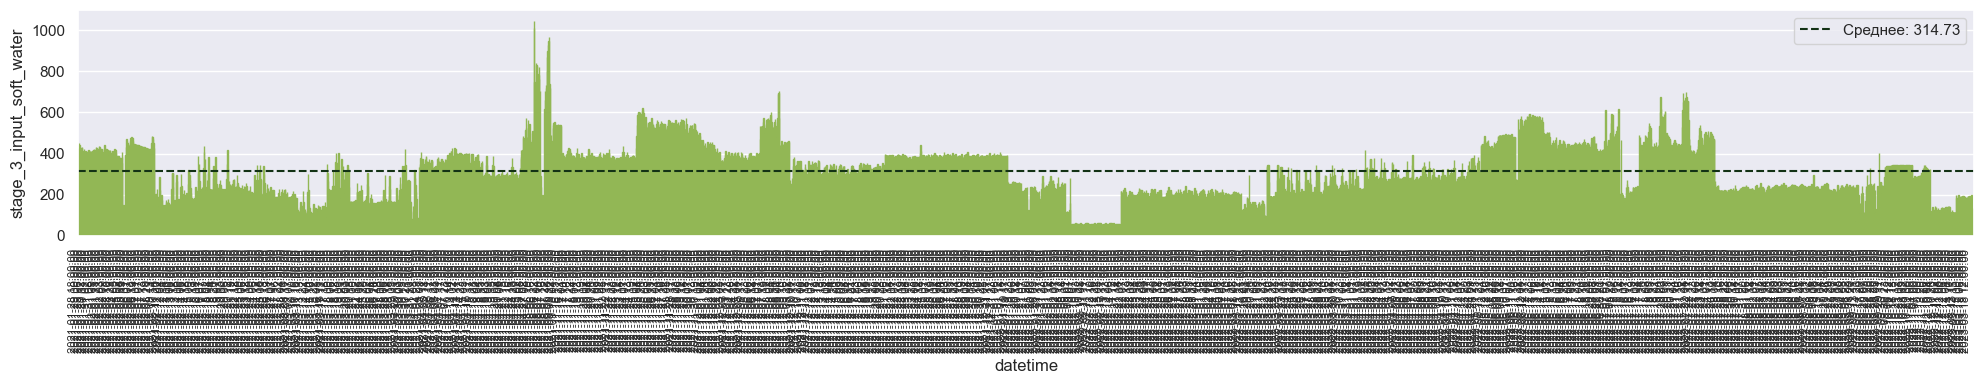

In [204]:
plt.figure(figsize=(20, 4))
x_ticks = df['datetime'][::6]  # или другой шаг, например [::5]

# Строим график
graph = sns.barplot(
    x='datetime', 
    y='stage_3_input_soft_water', 
    data=df, 
    color=color_for_histplot,
    edgecolor='#92B755'
)

# Настраиваем подписи оси X
graph.set_xticks(range(0, len(df['datetime'].unique()), 6))  # показываем метки через 7 значений
graph.set_xticklabels(x_ticks, rotation=90, ha='right', fontsize=8) 

# Добавляем линию среднего
mean_value = df['stage_3_input_soft_water'].mean()
plt.axhline(mean_value, color=color_for_line, linestyle='--', label=f'Среднее: {mean_value:.2f}')
plt.legend()

# Улучшаем отображение
plt.tight_layout()  # предотвращает обрезание подписей
plt.show()

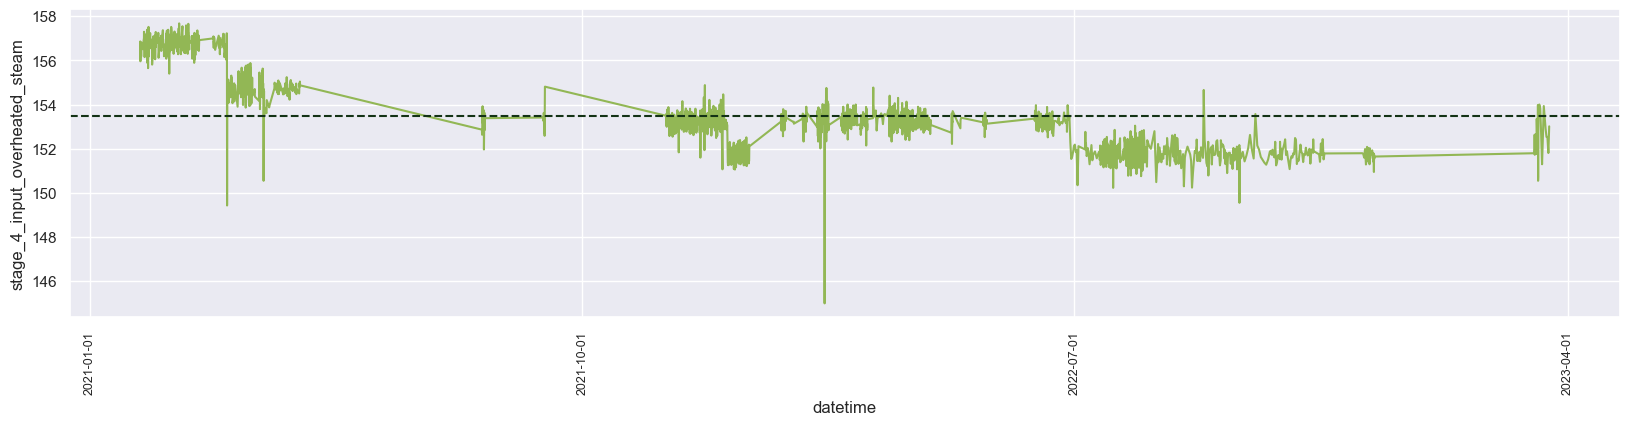

In [205]:
plt.figure(figsize=(20, 4))

graph = sns.lineplot(x='datetime', y='stage_4_input_overheated_steam', data=pivot_df, color=color_for_histplot)
graph.set_xticks(graph.get_xticks()[::3]) 
plt.xticks(rotation=90)
plt.xticks(fontsize=9)
mean_value = pivot_df['stage_4_input_overheated_steam'].mean()
plt.axhline(mean_value, color=color_for_line, linestyle='--', label=f'Среднее: {mean_value:.2f}')
plt.show()

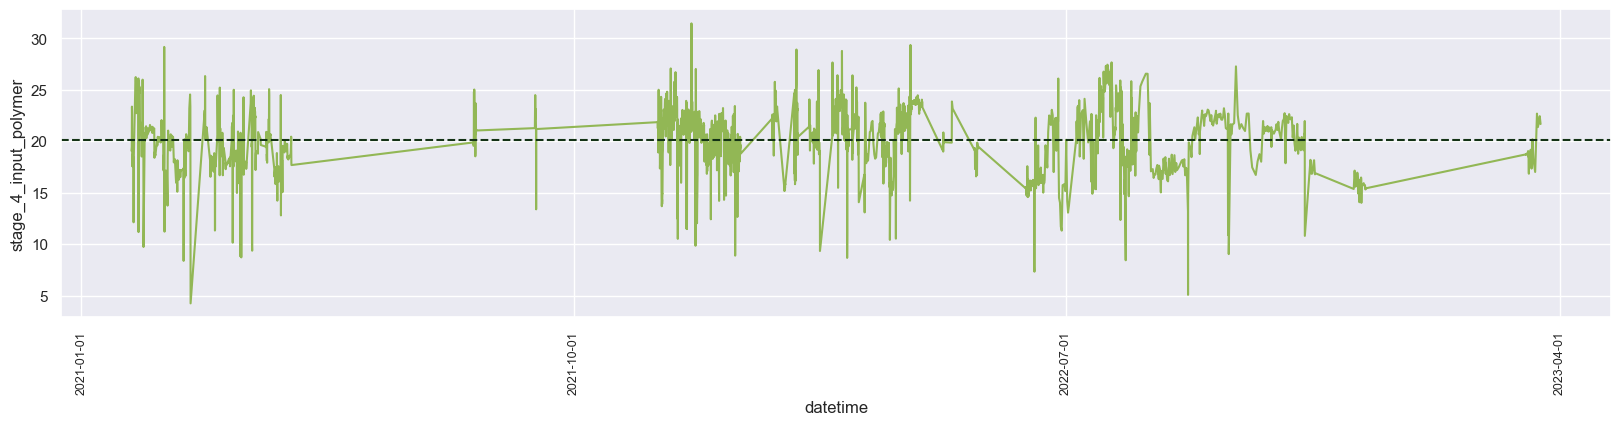

In [206]:
plt.figure(figsize=(20, 4))

graph = sns.lineplot(x='datetime', y='stage_4_input_polymer', data=pivot_df, color=color_for_histplot)
graph.set_xticks(graph.get_xticks()[::3]) 
plt.xticks(rotation=90)
plt.xticks(fontsize=9)
mean_value = pivot_df['stage_4_input_polymer'].mean()
plt.axhline(mean_value, color=color_for_line, linestyle='--', label=f'Среднее: {mean_value:.2f}')
plt.show()

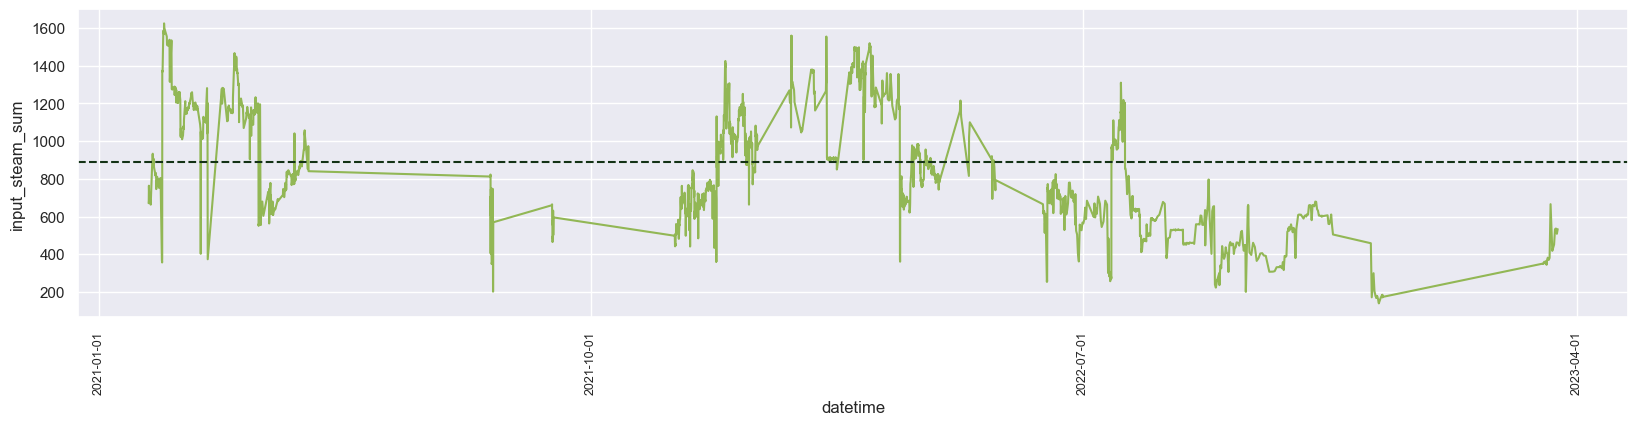

In [207]:
plt.figure(figsize=(20, 4))

graph = sns.lineplot(x='datetime', y='input_steam_sum', data=pivot_df, color=color_for_histplot)
graph.set_xticks(graph.get_xticks()[::3]) 
plt.xticks(rotation=90)
plt.xticks(fontsize=9)
mean_value = pivot_df['input_steam_sum'].mean()
plt.axhline(mean_value, color=color_for_line, linestyle='--', label=f'Среднее: {mean_value:.2f}')
plt.show()

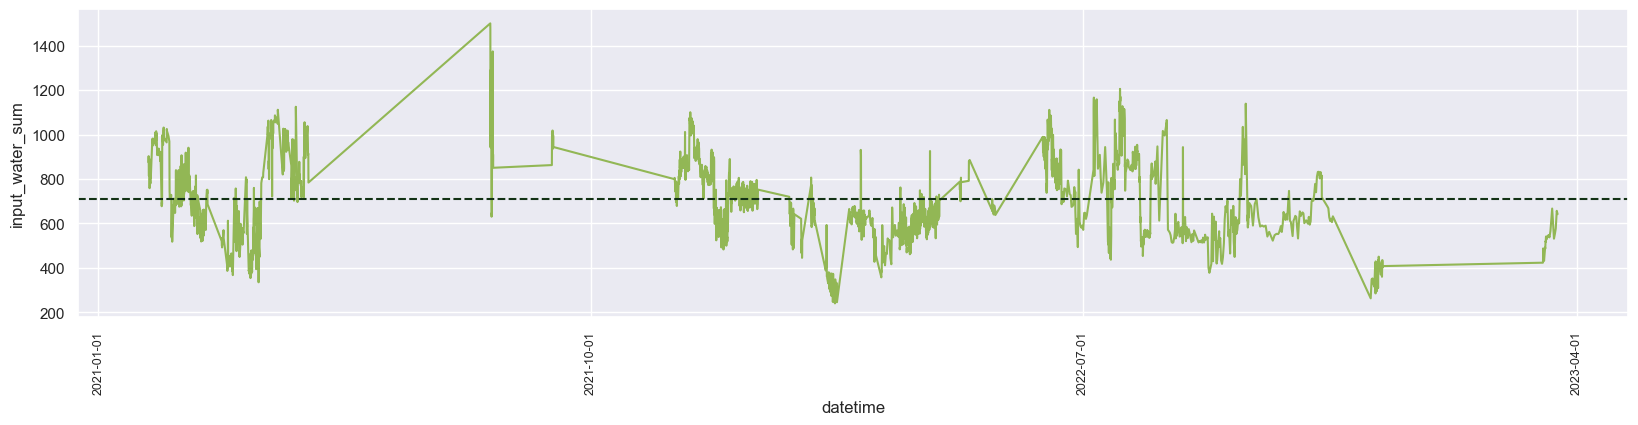

In [208]:
plt.figure(figsize=(20, 4))

graph = sns.lineplot(x='datetime', y='input_water_sum', data=pivot_df, color=color_for_histplot)
graph.set_xticks(graph.get_xticks()[::3])

plt.xticks(rotation=90)
plt.xticks(fontsize=9)
mean_value = pivot_df['input_water_sum'].mean()
plt.axhline(mean_value, color=color_for_line, linestyle='--', label=f'Среднее: {mean_value:.2f}')
plt.show()

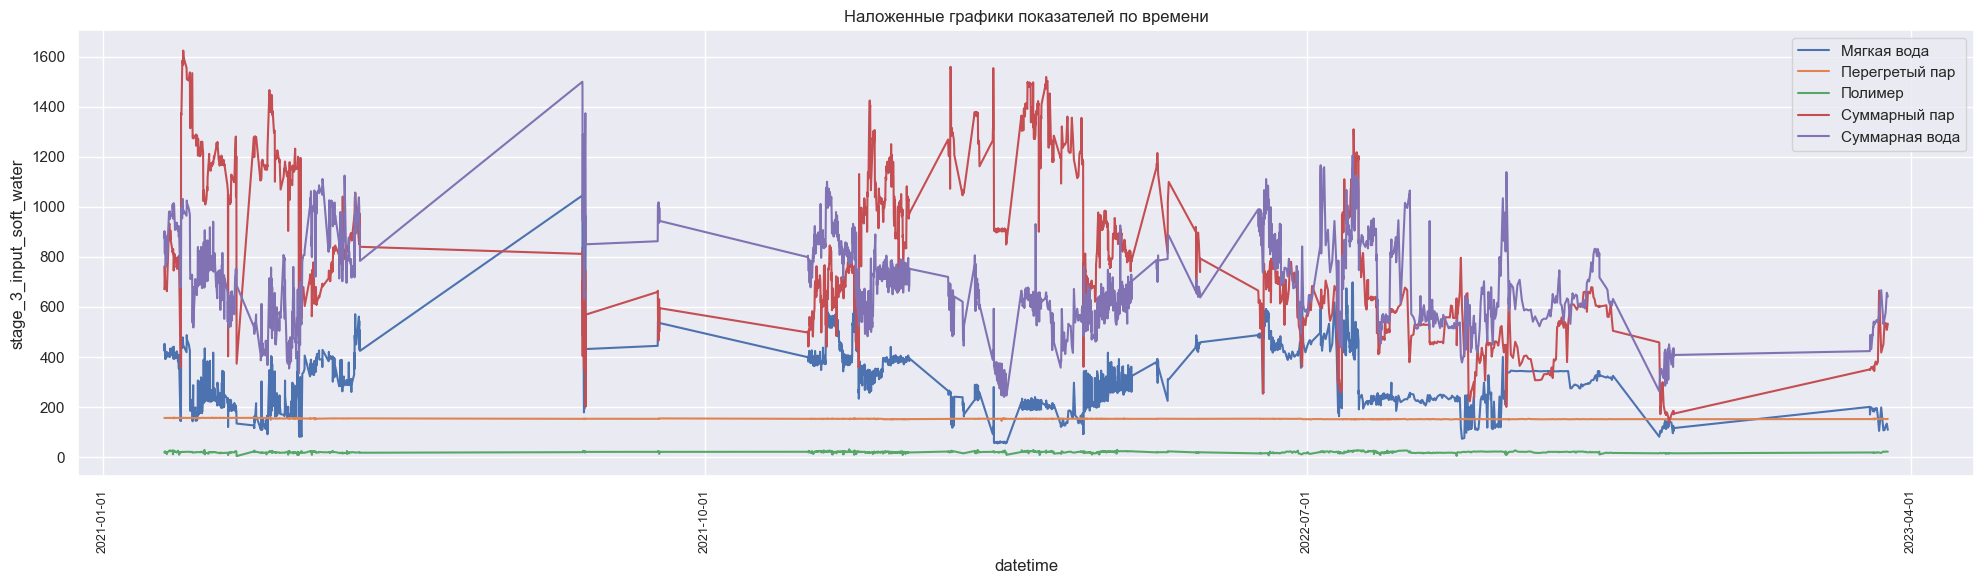

In [209]:
fig, ax = plt.subplots(figsize=(20, 6))

sns.lineplot(x='datetime', y='stage_3_input_soft_water', data=df, label='Мягкая вода', ax=ax)
sns.lineplot(x='datetime', y='stage_4_input_overheated_steam', data=pivot_df, label='Перегретый пар', ax=ax)
sns.lineplot(x='datetime', y='stage_4_input_polymer', data=pivot_df, label='Полимер', ax=ax)
sns.lineplot(x='datetime', y='input_steam_sum', data=pivot_df, label='Суммарный пар', ax=ax)
sns.lineplot(x='datetime', y='input_water_sum', data=pivot_df, label='Суммарная вода', ax=ax)

ax.set_xticks(ax.get_xticks()[::3])
plt.xticks(rotation=90, fontsize=9)

plt.legend()
plt.title('Наложенные графики показателей по времени')
plt.tight_layout()
plt.show()

Дневной расход ресурсов колеблеца постоянно, что говорит о нестбильности производства.  
К концу 2022 года (август) колебания умельнишились, что говорит о стабилизации процесса  
  
В среднем компания тратила больше ресурсов (продолжительном периоде) с 2021.08 до 2022.01  
Так же тратилось много (но меньше) ресурсов в период с 2022.03 до 2022.06

### Cводная таблица изменения категории опасности сгруппированная по месяцам

Обработаем даты

In [210]:
#df['datetime'] = df['datetime'].apply(lambda x: x[:-3])

In [211]:
for_table_df = df[['datetime', 'danger_gas_kat']]

for_table_df = for_table_df.groupby(['datetime'], as_index=False).value_counts()
pivot_table = for_table_df.pivot_table(index='datetime', aggfunc=mode)
pivot_table['danger_gas_kat'] = pivot_table['danger_gas_kat'].astype('int')
pivot_table

count  danger_gas_kat
datetime                                  
2021-01-28 21:00:00      1               3
2021-01-29 01:00:00      1               2
2021-01-29 08:00:00      1               2
2021-01-29 21:00:00      1               2
2021-01-30 01:00:00      1               2
...                    ...             ...
2023-03-19 12:00:00      1               3
2023-03-20 00:00:00      1               2
2023-03-20 12:00:00      1               3
2023-03-21 01:00:00      1               3
2023-03-21 12:00:00      1               3

[934 rows x 2 columns]

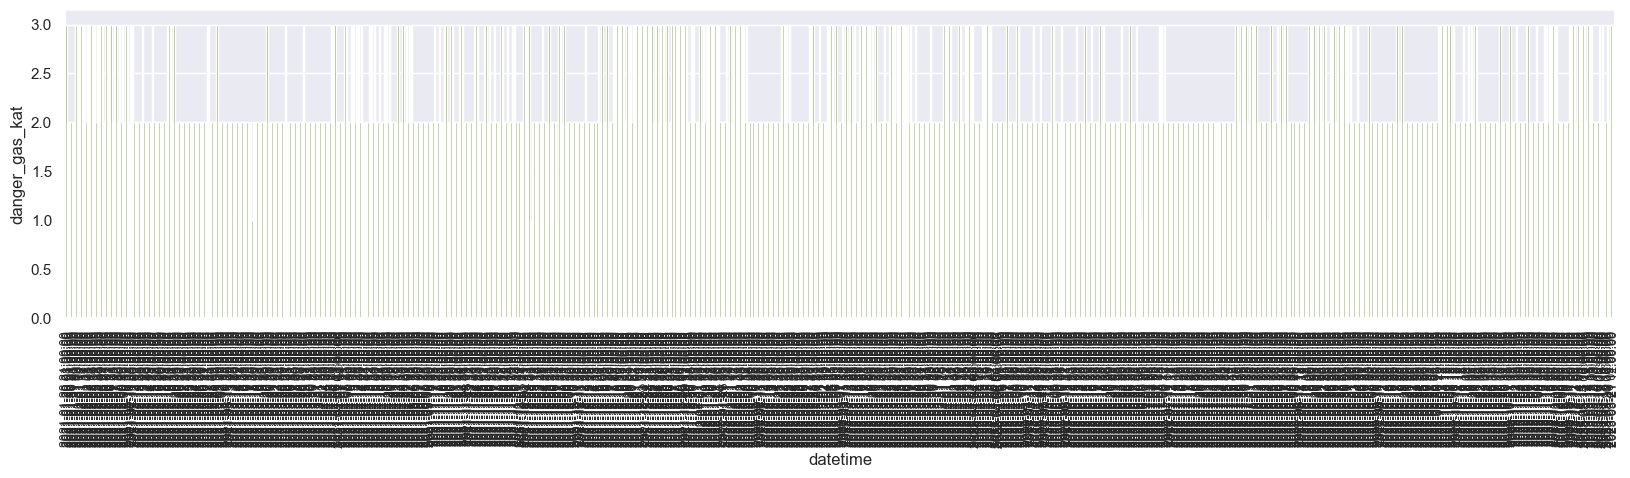

In [212]:
plt.figure(figsize=(20, 4))

graph = sns.barplot(x='datetime', y='danger_gas_kat', data=pivot_table, color=color_for_histplot)

plt.xticks(rotation=90)
plt.xticks(fontsize=9)
plt.show()

Наибольшая опасность была в период с 2021.12 - 2022.01 и 2023.03

### Среднее значение каждого параметра для каждой категории

In [213]:
curr_df = df.copy()

curr_df.drop(['datetime', 'work_shift'], axis=1, inplace=True)

group = curr_df.groupby(['danger_gas_kat']).mean()
group.to_string
group

stage_1_output_konv_avd  stage_2_input_water_sum  \
danger_gas_kat                                                     
1.0                           65.830000                80.640000   
2.0                           68.976546                87.832566   
3.0                           69.340514                86.472124   

                stage_2_output_bottom_pressure  stage_2_output_bottom_temp  \
danger_gas_kat                                                               
1.0                                 383.996000                   78.536000   
2.0                                 395.180049                   79.071448   
3.0                                 396.057695                   78.742850   

                stage_2_output_bottom_temp_hum_steam  \
danger_gas_kat                                         
1.0                                       101.944000   
2.0                                        98.325403   
3.0                                        97.468785   

                stage_2_output_bottom_vacuum  stage_2_output_top_pressure  \
danger_gas_kat                                                              
1.0                                56.360000                   450.904000   
2.0                                56.612352                   458.102042   
3.0                                56.763629                   443.630002   

                stage_2_output_top_pressure_at_end  stage_2_output_top_temp  \
danger_gas_kat                                                                
1.0                                     266.380000                93.890000   
2.0                                     262.250096                94.333553   
3.0                                     263.886760                94.933816   

                stage_2_output_top_vacuum  ...  stage_3_input_steam  \
danger_gas_kat                             ...                        
1.0                             58.212000  ...           756.620000   
2.0                             59.387829  ...           815.876645   
3.0                             56.929237  ...           837.982150   

                stage_3_output_temp_hum_steam  stage_3_output_temp_top  \
danger_gas_kat                                                           
1.0                                109.586000                41.268000   
2.0                                109.370403                42.183043   
3.0                                109.972574                42.487926   

                stage_4_input_overheated_steam  stage_4_input_polymer  \
danger_gas_kat                                                          
1.0                                 153.314000              18.092000   
2.0                                 153.348141              20.083720   
3.0                                 153.236044              20.166757   

                stage_4_input_steam  stage_4_input_water  \
danger_gas_kat                                             
1.0                        4.612000            232.05000   
2.0                        5.217163            297.56477   
3.0                        5.597788            312.85352   

                stage_4_output_danger_gas  stage_4_output_dry_residue_avg  \
danger_gas_kat                                                              
1.0                              0.036000                       21.800000   
2.0                              0.119079                       22.222434   
3.0                              0.181651                       22.525171   

                stage_4_output_product  
danger_gas_kat                          
1.0                          43.484000  
2.0                          44.234852  
3.0                          42.330779  

[3 rows x 22 columns]

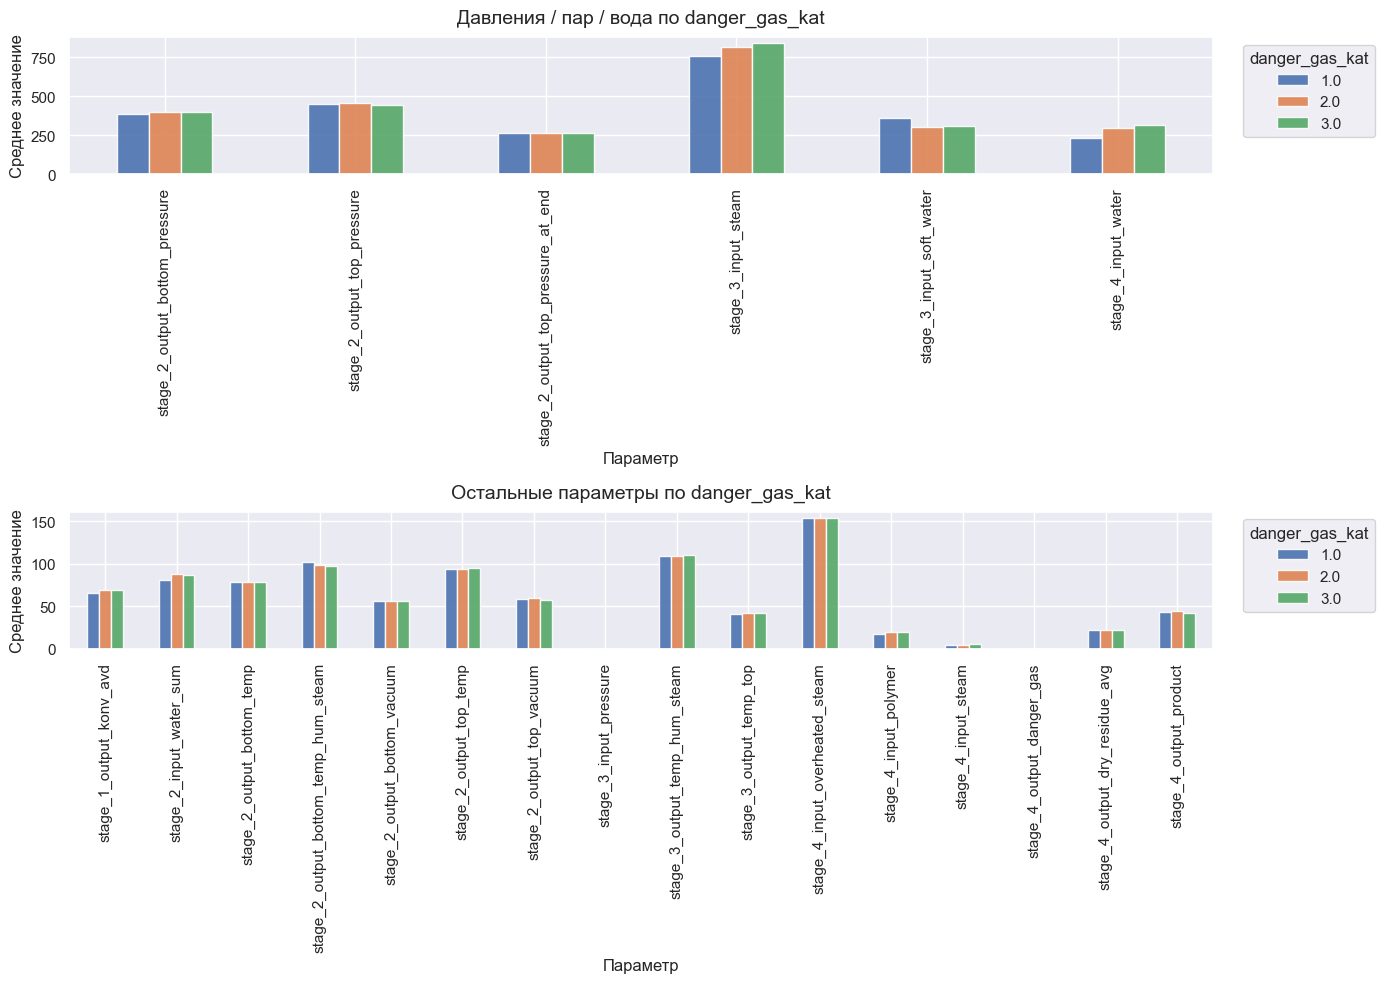

In [214]:
pressure_cols = [
    'stage_2_output_bottom_pressure',
    'stage_2_output_top_pressure',
    'stage_2_output_top_pressure_at_end',
    'stage_3_input_steam',
    'stage_3_input_soft_water',
    'stage_4_input_water'
]

df_press  = group[pressure_cols]                  
df_others = group.drop(columns=pressure_cols)  

fig, (ax1, ax2) = plt.subplots(
    nrows=2, figsize=(14, 10),
    sharex=False, sharey=False    
)


df_press.T.plot(kind='bar', ax=ax1, alpha=0.9)
ax1.set_title('Давления / пар / вода по danger_gas_kat', fontsize=14, pad=10)
ax1.set_xlabel('Параметр')
ax1.set_ylabel('Среднее значение')
ax1.legend(title='danger_gas_kat', bbox_to_anchor=(1.02, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=90)

df_others.T.plot(kind='bar', ax=ax2, alpha=0.9)
ax2.set_title('Остальные параметры по danger_gas_kat', fontsize=14, pad=10)
ax2.set_xlabel('Параметр')
ax2.set_ylabel('Среднее значение')
ax2.legend(title='danger_gas_kat', bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### Корреляционный анализ

<Axes: >

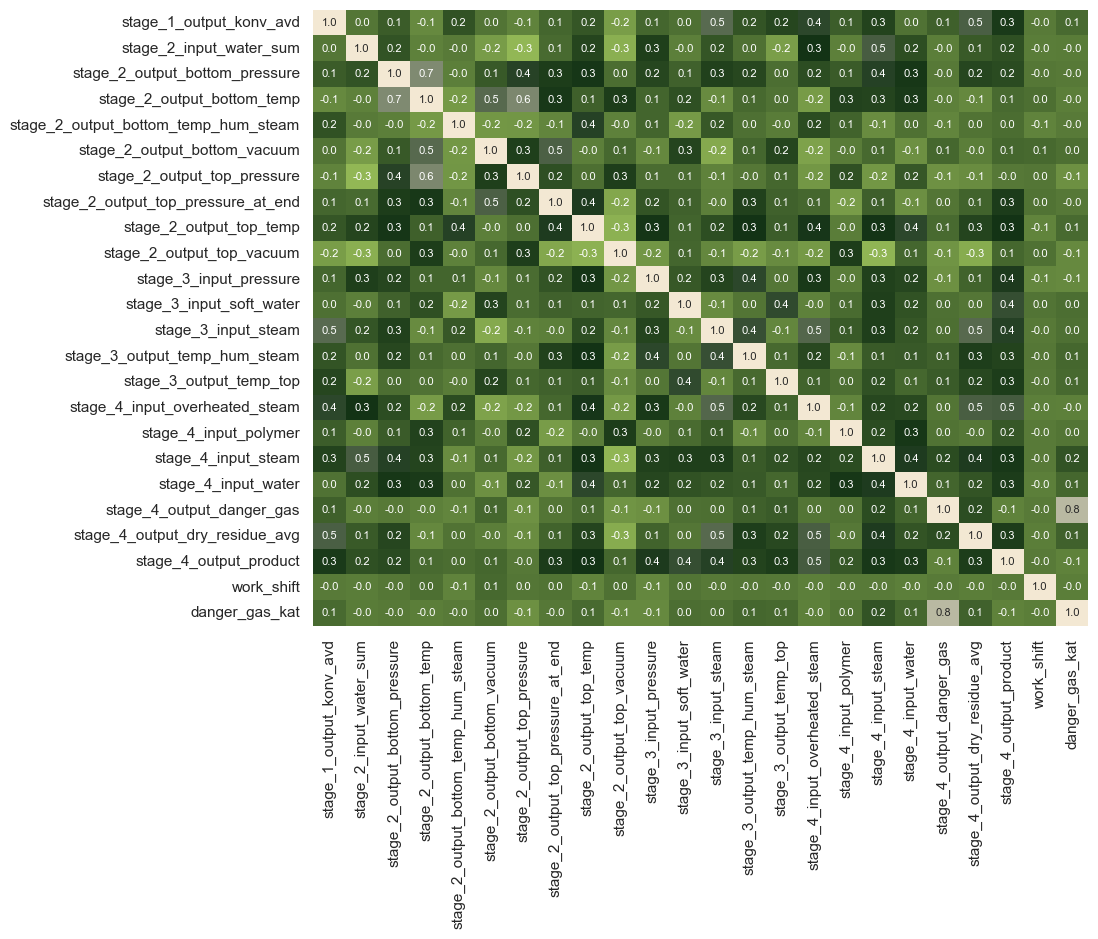

In [215]:
df_filtered = df.dropna(subset=['stage_4_output_danger_gas'])
custom_gradient = LinearSegmentedColormap.from_list("CorporateGradient", corporate_colors)
spec_df = df_filtered.drop('datetime', axis=1)
correlation_matrix = spec_df.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap=custom_gradient, fmt='.1f', cbar=False, annot=True, annot_kws={"size": 8})

## Проверка гипотез

Функция для проверки нормольности распределения данных

In [216]:
def raspder(x):
    koalit = []
    for i in x.columns:
        _, res = shapiro(x[i])
        if res >= 0.05:
            koalit.append([i, 'нормальное'])
        else:
            koalit.append([i, 'ненормальное'])
    return pd.DataFrame(koalit, columns=['Параметр', 'Распределение'])

### Гипотеза 1. Если ли различия в доле опасного газа от смены?

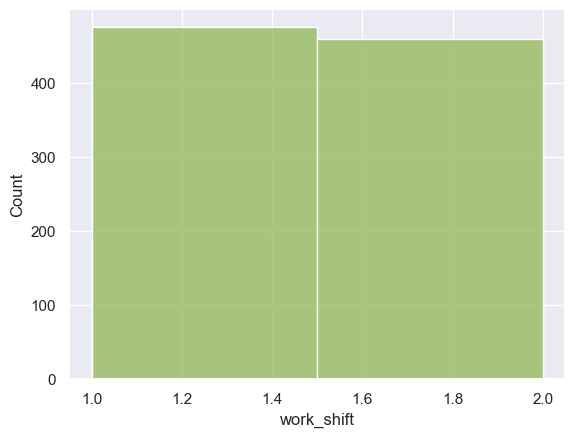

In [226]:
cor_df = df[['work_shift', 'stage_4_output_danger_gas']].copy()
cor_df = cor_df.dropna(subset=['stage_4_output_danger_gas']).reset_index(drop=True)

sns.histplot(cor_df['work_shift'], bins=2, color=color_for_histplot, line_kws=line)
plt.show()

In [218]:
res_1 = cor_df[cor_df['work_shift'] == 1]
res_2 = cor_df[cor_df['work_shift'] == 2]

In [220]:
res_1

work_shift  stage_4_output_danger_gas
2             1                       0.13
3             1                       0.14
4             1                       0.15
5             1                       0.14
6             1                       0.18
..          ...                        ...
926           1                       0.17
927           1                       0.15
931           1                       0.20
932           1                       0.18
933           1                       0.20

[475 rows x 2 columns]

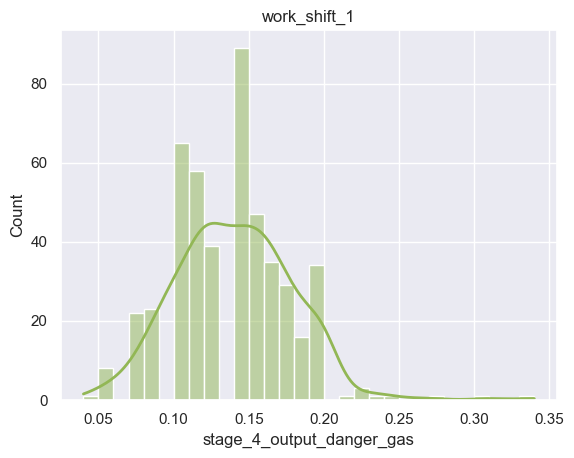

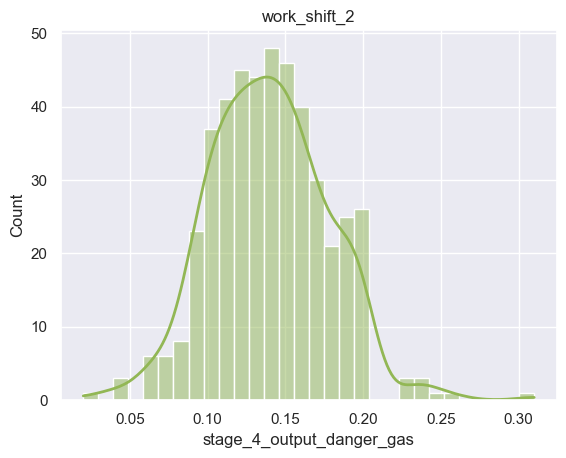

In [224]:
plt.title("work_shift_1")
sns.histplot(res_1['stage_4_output_danger_gas'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

plt.title("work_shift_2")
sns.histplot(res_2['stage_4_output_danger_gas'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [ ]:
raspder(cor_df)

Параметр Распределение
0                 work_shift  ненормальное
1  stage_4_output_danger_gas  ненормальное

Визуально и c помощью shapiro видно, что распределения не нормальные, значит будем сравнивать медианы

#### Составим гипотезы
т.к медианы, то различия по медианам

H₀ = Между work_shift и stage_4_output_danger_gas нет различий в медиане

H₁ = Между work_shift и stage_4_output_danger_gas существует различия в медиане

для этого подойдет тест Манна — Уитни 
Сначала разделим данные по сменам

In [ ]:
res_1

work_shift  stage_3_output_temp_top
14           1.0                    46.10
15           1.0                    46.11
16           1.0                    46.13
17           1.0                    46.25
18           1.0                    46.38
...          ...                      ...
4392         1.0                    46.56
4393         1.0                    42.34
4397         1.0                    45.99
4398         1.0                    47.70
4399         1.0                    43.42

[2122 rows x 2 columns]

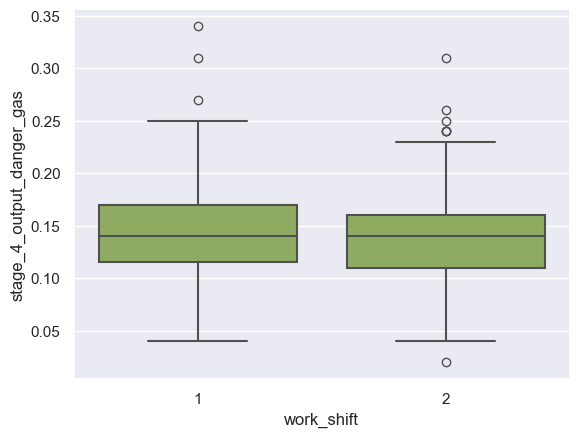

Коэффициент корреляции(static): [      0. 2091417.]
P-уровень: [0.         0.97366594]


In [ ]:
sns.boxplot(x='work_shift', y='stage_4_output_danger_gas', data=cor_df, color=color_for_histplot, linewidth=1.5)
plt.show()

stat, p_value = mannwhitneyu(res_1, res_2, alternative='two-sided')

print(f"Коэффициент корреляции(static): {stat}")
print(f"P-уровень: {p_value}")

Значение P-уровня > 0.05, т.е нет оснований отвергнуть нулевую гипотезу в пользу альтернативной. Если различия и есть, то они носят случайный характер

### Гипотеза 2. Какая из смен лучше управляет температурой верха на этапе 3?

In [227]:
cor_df = df[['work_shift', 'stage_3_output_temp_top']].copy()

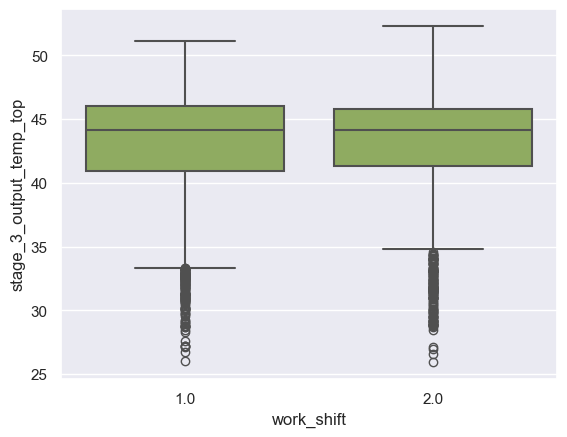

In [228]:
sns.boxplot(x='work_shift', y='stage_3_output_temp_top', data=cor_df, color=color_for_histplot, linewidth=1.5)
plt.show()

In [230]:
res_1 = cor_df[cor_df['work_shift'] == 1]
res_2 = cor_df[cor_df['work_shift'] == 2]

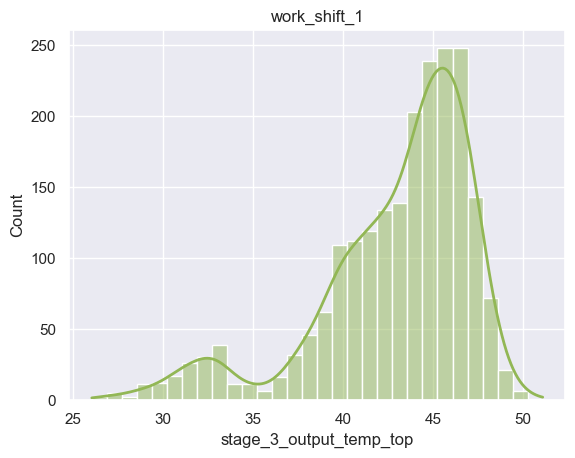

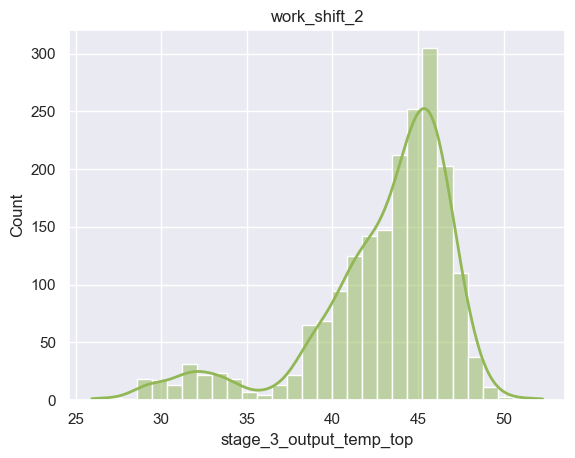

In [231]:
plt.title("work_shift_1")
sns.histplot(res_1['stage_3_output_temp_top'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

plt.title("work_shift_2")
sns.histplot(res_2['stage_3_output_temp_top'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [ ]:
raspder(cor_df)

Параметр Распределение
0               work_shift  ненормальное
1  stage_3_output_temp_top  ненормальное

In [ ]:
Оба распределения не нормальные

#### Составим гипотезы
H₀ = Нет различий в медиане температуры верха между сменами.  

H₁ = Есть различия медиан температура верха отличается между сменами.  

In [ ]:
stat, p_value = mannwhitneyu(res_1, res_2, alternative='two-sided')

print(f"Коэффициент корреляции(static): {stat}")
print(f"P-уровень: {p_value}")

Коэффициент корреляции(static): [      0. 2091417.]
P-уровень: [0.         0.97366594]


P-уровень: 0.6083 > 0.05, нет оснований отвергнуть нулевую гипотезу в пользу альтернативной. Т.е если различия между температурами верхов носят случайный характер

### Гипотеза 3. Конверсия мономера на 1 этапе влияет на количество подаваемой суммарной воды.

In [ ]:
gip_3 = df[['stage_1_output_konv_avd', 'stage_2_input_water_sum']]
gip_3.head()

stage_1_output_konv_avd  stage_2_input_water_sum
0                    67.83                    92.99
1                    67.83                    91.82
2                    67.83                    90.65
3                    67.93                    90.24
4                    68.03                    89.84

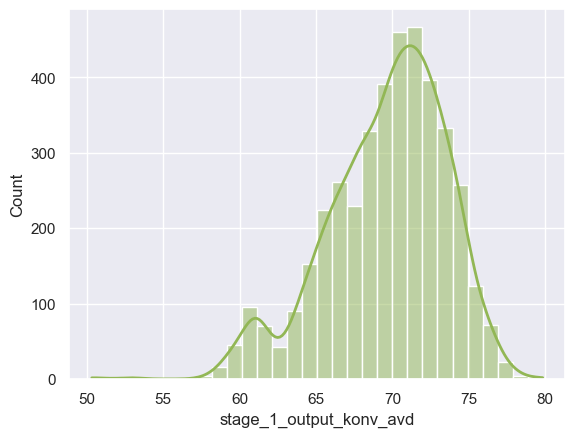

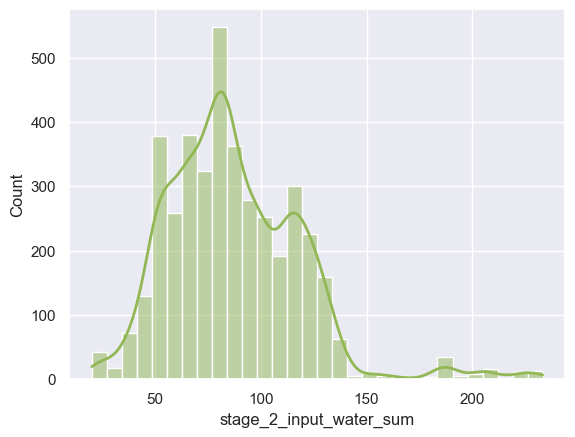

In [ ]:
sns.histplot(gip_3['stage_1_output_konv_avd'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()
sns.histplot(gip_3['stage_2_input_water_sum'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [232]:
raspder(gip_3)

Параметр Распределение
0  stage_1_output_konv_avd  ненормальное
1  stage_2_input_water_sum  ненормальное

оба распределения не нормальны

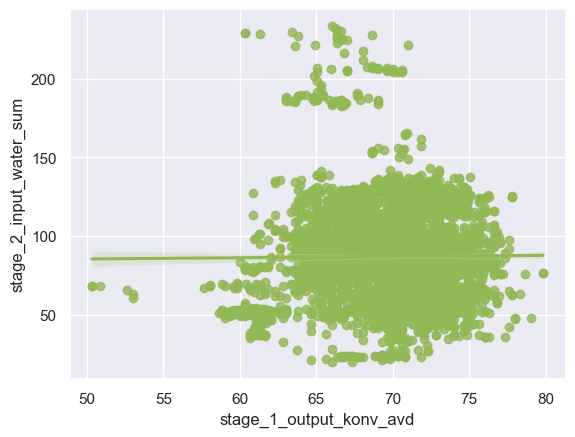

In [ ]:
sns.regplot(x='stage_1_output_konv_avd', y='stage_2_input_water_sum', data=gip_3, color=color_for_histplot)
plt.show()

Т.к линия горизонтальная, то можно сказать что значение корреляции стремится к 0

#### Составим гипотезы
H₀ = Между медианами stage_1_output_konv_avd и stage_2_input_water_sum различия носят исключительно случайный характер

H₁ = Между медианами stage_1_output_konv_avd и stage_2_input_water_sum есть различия 

In [233]:
cor, p_value = mannwhitneyu(gip_3['stage_1_output_konv_avd'], gip_3['stage_2_input_water_sum'])
print(f"Корреляция: {cor}")
print(f"P-значение: {p_value}")

Корреляция: 5117426.0
P-значение: 9.851368213400699e-204


P-уровень: 0.9651 > 0.05, нет оснований отвергнуть нулевую гипотезу в пользу альтернативной. Получается, между stage_1_output_konv_avd не влияет на stage_2_input_water_sum

### Гипотеза 4. Количество выходного количества продукта связано с долей опасного газа.

In [ ]:
gip_4 = df[['stage_4_output_product', 'stage_4_output_danger_gas']]
gip_4 = gip_4.dropna(subset=['stage_4_output_danger_gas']).reset_index(drop=True)
gip_4.head()

stage_4_output_product  stage_4_output_danger_gas
0                   46.01                       0.16
1                   52.55                       0.15
2                   42.99                       0.13
3                   43.67                       0.14
4                   47.43                       0.15

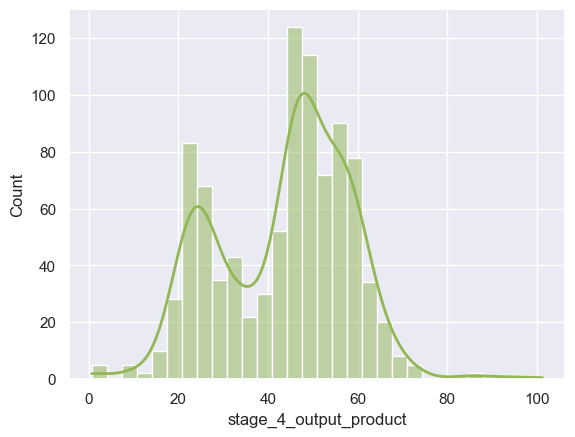

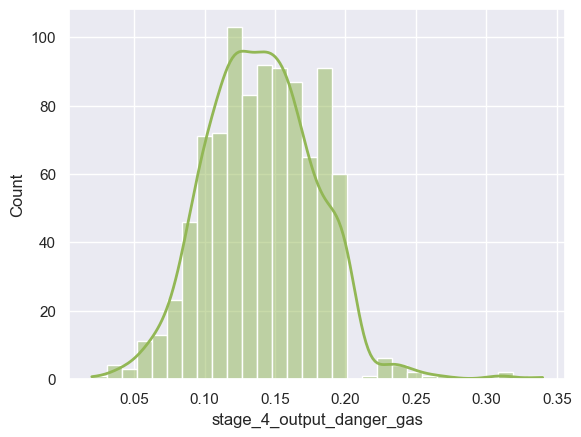

In [ ]:
sns.histplot(gip_4['stage_4_output_product'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()
sns.histplot(gip_4['stage_4_output_danger_gas'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [ ]:
raspder(gip_4)

Параметр Распределение
0     stage_4_output_product  ненормальное
1  stage_4_output_danger_gas  ненормальное

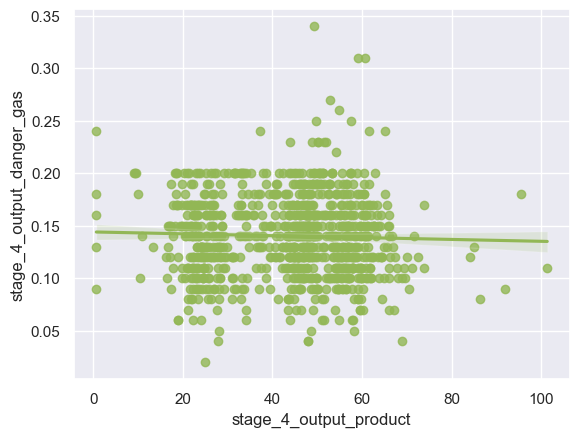

In [ ]:
sns.regplot(x='stage_4_output_product', y='stage_4_output_danger_gas', data=gip_4, color=color_for_histplot)
plt.show()

Т.к линия почти горизонтальная, то можно сказать что значение корреляции не сильно высоко

#### Составим гипотезы
H₀ = Между медианами stage_4_output_product и stage_4_output_danger_gas зависимости имеют исключительно случайных характер  
H₁ = МеМежду медианамижду stage_4_output_product и stage_4_output_danger_gas есть различия

In [ ]:
cor, p_value = mannwhitneyu(gip_4['stage_4_output_product'], gip_4['stage_4_output_danger_gas'])
print(f"Корреляция: {cor}")
print(f"P-значение: {p_value}")

Корреляция: 872356.0
P-значение: 1.0402439135695203e-306


P-уровень: 0.1142 > 0.05, нет оснований отвергнуть нулевую гипотезу в пользу альтернативной.

### Гипотеза 5 Количество выходного продукта связано с количеством перегретого пара.

In [ ]:
gip_5 = df[['stage_4_output_product', 'stage_4_input_overheated_steam']]
gip_5.head()

stage_4_output_product  stage_4_input_overheated_steam
0                   47.03                          156.67
1                   45.05                          156.76
2                   43.06                          156.86
3                   46.01                          156.41
4                   48.95                          155.96

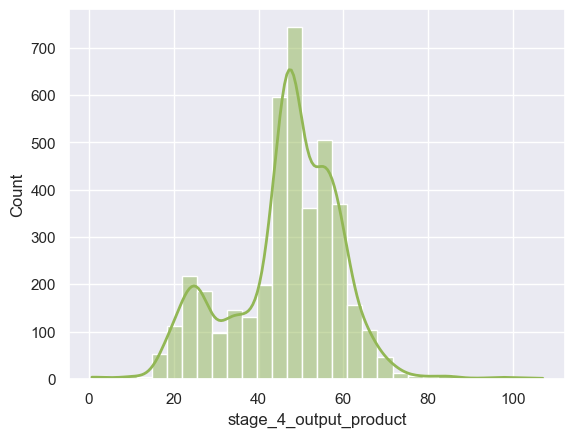

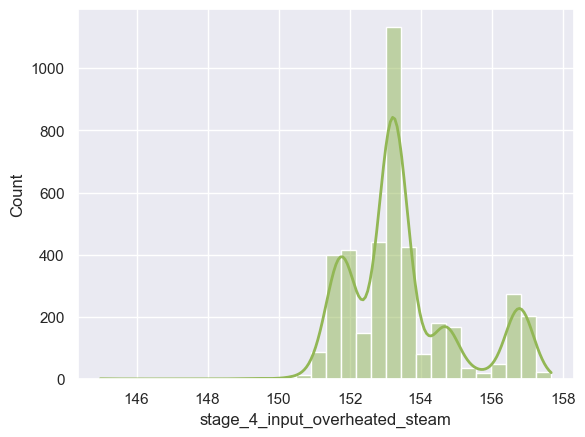

In [ ]:
sns.histplot(gip_5['stage_4_output_product'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()
sns.histplot(gip_5['stage_4_input_overheated_steam'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [ ]:
raspder(gip_5)

Параметр Распределение
0          stage_4_output_product  ненормальное
1  stage_4_input_overheated_steam  ненормальное

оба распределения не нормальны

H₀ = Между медианами stage_4_output_product и stage_4_input_overheated_steam различия имеют исключительно случайных характер

H₁ = Между медианами stage_4_output_product и stage_4_input_overheated_steam есть различия

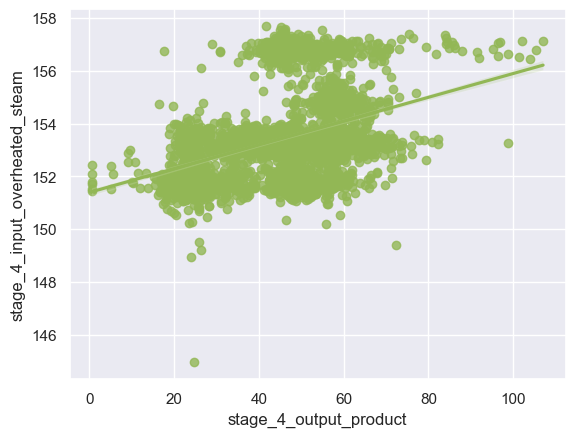

In [ ]:
sns.regplot(x='stage_4_output_product', y='stage_4_input_overheated_steam', data=gip_5, color=color_for_histplot)
plt.show()

In [234]:
cor, p_value = mannwhitneyu(gip_5['stage_4_output_product'], gip_5['stage_4_input_overheated_steam'])
cor, p_value

(0.0, 0.0)

P-уровень: 1.3232433365005924e-116 > 0.05, отклоняем нулевую гипотезу и принимаем альтернативную гипотезу, поскольку результаты статистического теста показывают, что связь является статистически значимой.

### Гипотеза 6 Процент сухого остатка финального продукта связан с процентом конверсии сырья в мономер.

In [ ]:
gip_6 = df[['stage_4_output_dry_residue_avg', 'stage_1_output_konv_avd']]
gip_6

stage_4_output_dry_residue_avg  stage_1_output_konv_avd
0                              21.48                    67.83
1                              21.48                    67.83
2                              21.48                    67.83
3                              21.48                    67.93
4                              21.48                    68.03
...                              ...                      ...
4395                           21.18                    67.33
4396                           21.08                    68.83
4397                           21.08                    66.83
4398                           22.38                    70.03
4399                           22.18                    66.83

[4092 rows x 2 columns]

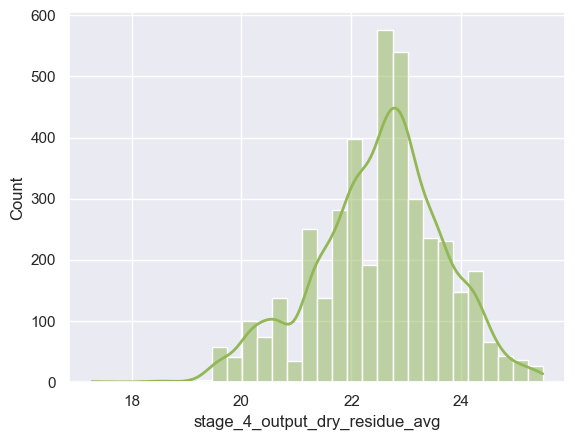

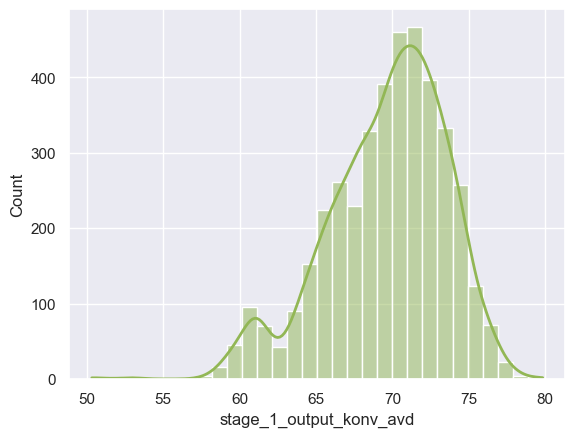

In [ ]:
sns.histplot(gip_6['stage_4_output_dry_residue_avg'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()
sns.histplot(gip_6['stage_1_output_konv_avd'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [ ]:
raspder(gip_6)

Параметр Распределение
0  stage_4_output_dry_residue_avg  ненормальное
1         stage_1_output_konv_avd  ненормальное

оба распределения не нормальные

H₀ = Между медианами stage_4_output_dry_residue_avg и stage_1_output_konv_avd различия носят исключительно случайный характер

H₁ = Между stage_4_output_dry_residue_avg и stage_1_output_konv_avd различия носят не случайных характер

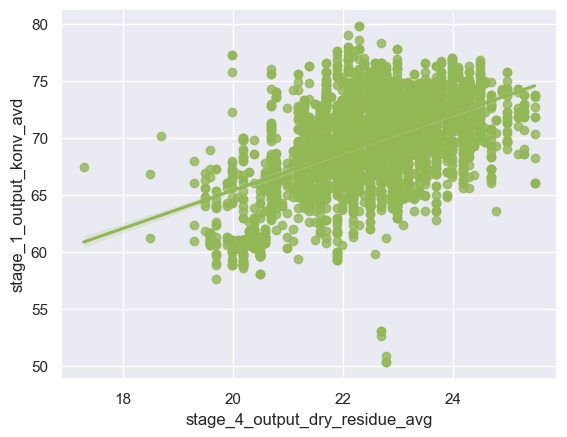

In [ ]:
sns.regplot(x='stage_4_output_dry_residue_avg', y='stage_1_output_konv_avd', data=gip_6, color=color_for_histplot)
plt.show()

In [ ]:
cor, p_value = mannwhitneyu(gip_6['stage_4_output_dry_residue_avg'], gip_6['stage_1_output_konv_avd'])
cor, p_value

(0.0, 0.0)

P-уровень: 8.405641322179748e-182 > 0.05, отклоняем нулевую гипотезу и принимаем альтернативную гипотезу, поскольку результаты статистического теста показывают, что связь является статистически значимой.

### Гипотеза 7 Процент сухого остатка финального продукта связан с количеством подаваемого пара на 3м этапе.

In [ ]:
gip_7 = df[['stage_4_output_dry_residue_avg', 'stage_3_input_steam']]
gip_7

stage_4_output_dry_residue_avg  stage_3_input_steam
0                              21.48               664.93
1                              21.48               671.68
2                              21.48               678.44
3                              21.48               717.99
4                              21.48               757.55
...                              ...                  ...
4395                           21.18               447.43
4396                           21.08               528.42
4397                           21.08               532.37
4398                           22.38               504.74
4399                           22.18               529.99

[4092 rows x 2 columns]

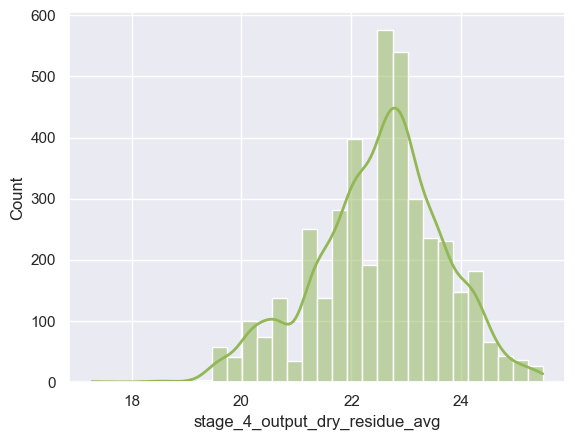

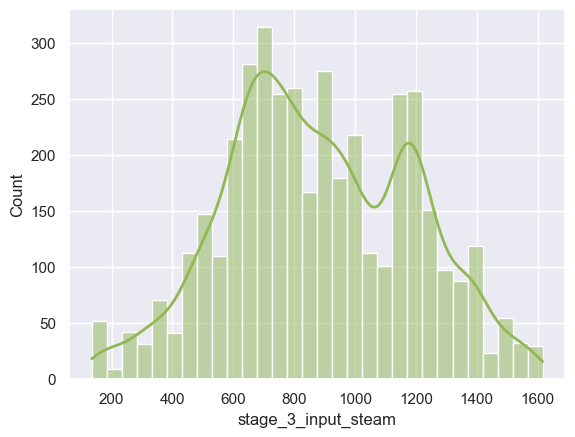

In [ ]:
sns.histplot(gip_7['stage_4_output_dry_residue_avg'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()
sns.histplot(gip_7['stage_3_input_steam'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [ ]:
raspder(gip_7)

Параметр Распределение
0  stage_4_output_dry_residue_avg  ненормальное
1             stage_3_input_steam  ненормальное

оба распределения не нормальные

H₀ = Между медианами stage_4_output_dry_residue_avg и stage_3_input_steam различия носят исключительно случайный характер
H₁ = Между медианами stage_4_output_dry_residue_avg и stage_3_input_steam различия не случайны

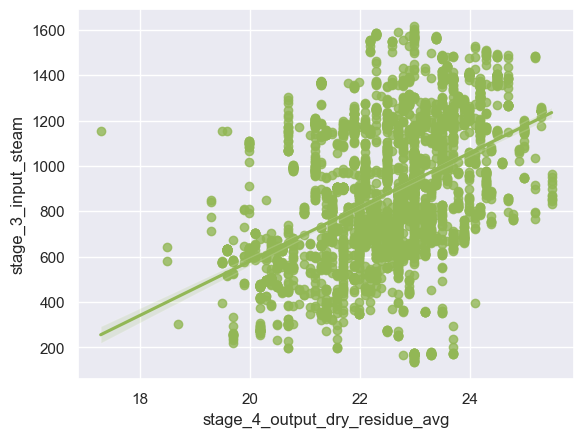

In [ ]:
sns.regplot(x='stage_4_output_dry_residue_avg', y='stage_3_input_steam', data=gip_7, color=color_for_histplot)
plt.show()

In [ ]:
cor, p_value = mannwhitneyu(gip_7['stage_4_output_dry_residue_avg'], gip_7['stage_3_input_steam'])
cor, p_value

(0.0, 0.0)

P-уровень: 6.418108817574982e-221 > 0.05, отклоняем нулевую гипотезу и принимаем альтернативную гипотезу, поскольку результаты статистического теста показывают, что связь является статистически значимой.

### Гипотеза 8 Количество итогового продукта связано с количеством мягкой воды, поданной на 3м этапе.

In [ ]:
gip_8 = df[['stage_4_output_product', 'stage_3_input_soft_water']]
gip_8

stage_4_output_product  stage_3_input_soft_water
0                      47.03                    426.06
1                      45.05                    439.41
2                      43.06                    452.76
3                      46.01                    440.25
4                      48.95                    427.74
...                      ...                       ...
4395                    9.17                    107.02
4396                   10.79                    108.57
4397                    9.27                    124.21
4398                   10.11                    133.94
4399                    9.59                    109.08

[4092 rows x 2 columns]

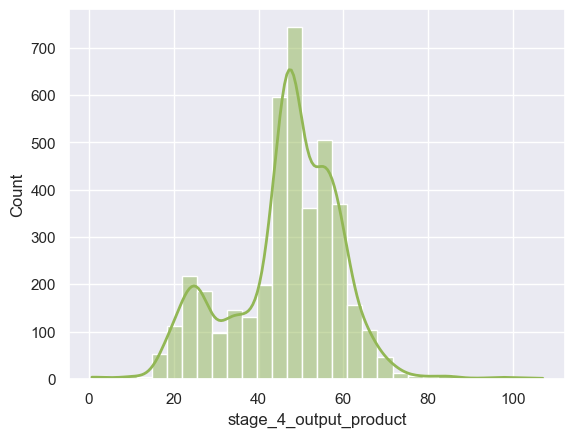

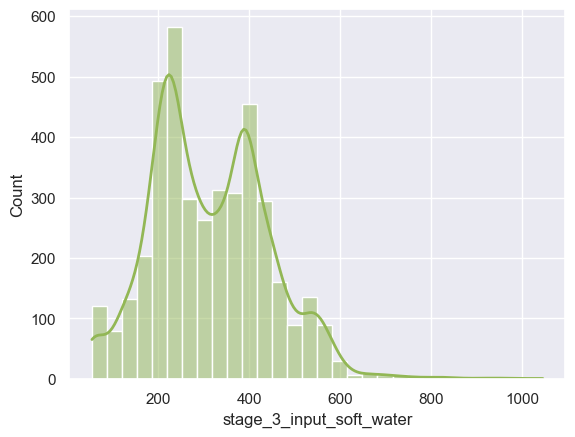

In [ ]:
sns.histplot(gip_8['stage_4_output_product'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()
sns.histplot(gip_8['stage_3_input_soft_water'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [ ]:
raspder(gip_8)

Параметр Распределение
0    stage_4_output_product  ненормальное
1  stage_3_input_soft_water  ненормальное

оба распределения не нормальные

H₀ = Между медианами stage_4_output_product и stage_3_input_soft_water различия носят исключительно случайный характер
H₁ = Между медианами stage_4_output_product и stage_3_input_soft_water различия не случайны

<Axes: xlabel='stage_4_output_product', ylabel='stage_3_input_soft_water'>

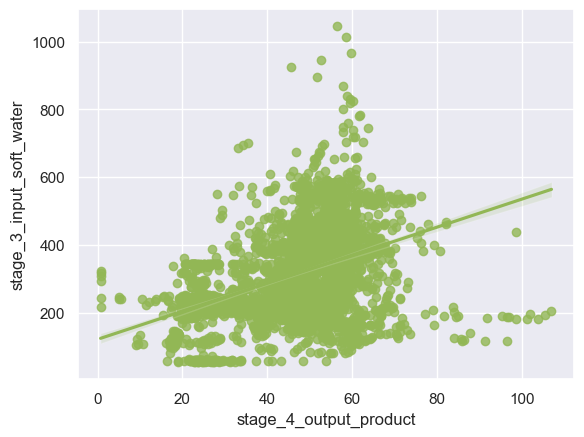

In [ ]:
sns.regplot(x='stage_4_output_product', y='stage_3_input_soft_water', data=gip_8, color=color_for_histplot)
plt.show()

In [235]:
cor, p_value = mannwhitneyu(gip_8['stage_4_output_product'], gip_8['stage_3_input_soft_water'])
cor, p_value

(61905.0, 0.0)

P-уровень: 3.4688128672169747e-188 > 0.05, отклоняем нулевую гипотезу и принимаем альтернативную гипотезу, поскольку результаты статистического теста показывают, что связь является статистически значимой.

### Гипотеза 9 Процент сухого остатка финального продукта связан с количеством перегретого пара.

In [ ]:
gip_9 = df[['stage_4_output_dry_residue_avg', 'stage_4_input_overheated_steam']]
gip_9

stage_4_output_dry_residue_avg  stage_4_input_overheated_steam
0                              21.48                          156.67
1                              21.48                          156.76
2                              21.48                          156.86
3                              21.48                          156.41
4                              21.48                          155.96
...                              ...                             ...
4395                           21.18                          152.90
4396                           21.08                          152.53
4397                           21.08                          152.53
4398                           22.38                          151.80
4399                           22.18                          153.01

[4092 rows x 2 columns]

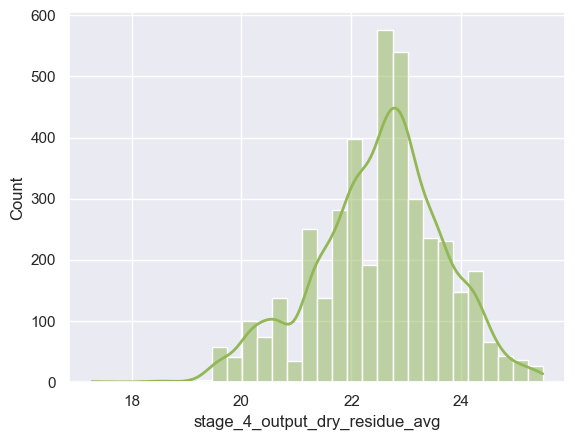

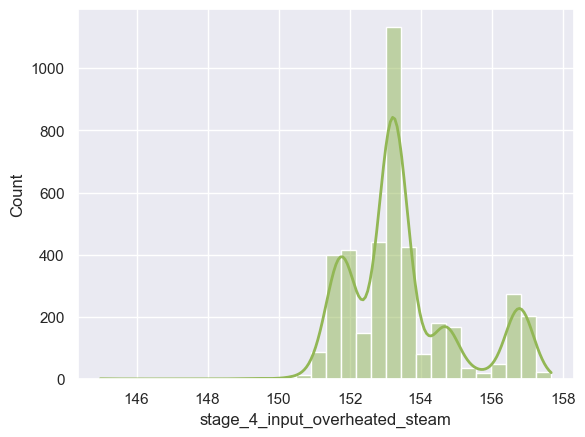

In [ ]:
sns.histplot(gip_9['stage_4_output_dry_residue_avg'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()
sns.histplot(gip_9['stage_4_input_overheated_steam'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [ ]:
raspder(gip_9)

Параметр Распределение
0  stage_4_output_dry_residue_avg  ненормальное
1  stage_4_input_overheated_steam  ненормальное

оба распределения не нормальные

H₀ = Между медианами stage_4_input_overheated_steam и stage_4_output_dry_residue_avg различия носят исключительно случайно случайный характер

H₁ = Между медианами stage_4_input_overheated_steam и stage_4_output_dry_residue_avg различия не случайны

<Axes: xlabel='stage_4_input_overheated_steam', ylabel='stage_4_output_dry_residue_avg'>

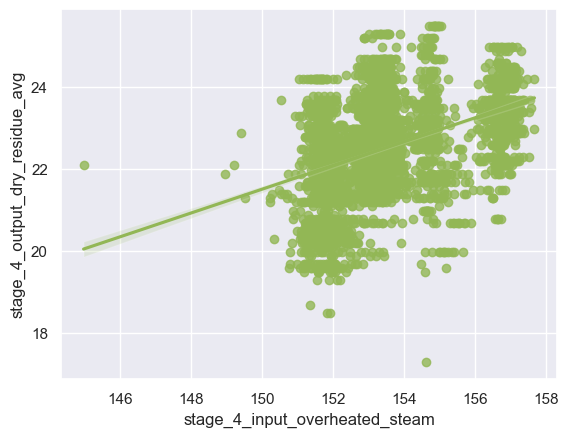

In [ ]:
sns.regplot(x='stage_4_input_overheated_steam', y='stage_4_output_dry_residue_avg', data=gip_9, color=color_for_histplot)
plt.show()

In [236]:
cor, p_value = mannwhitneyu(gip_9['stage_4_input_overheated_steam'], gip_9['stage_4_output_dry_residue_avg'])
cor, p_value

(16744464.0, 0.0)

P-уровень: 1.82530590340055e-153 > 0.05, отклоняем нулевую гипотезу и принимаем альтернативную гипотезу, поскольку результаты статистического теста показывают, что связь является статистически значимой.

### Гипотеза 10 Количество готового продукта связано с температура насыщенного пара.

In [ ]:
gip_10 = df[['stage_4_output_product', 'stage_3_output_temp_hum_steam']]
gip_10

stage_4_output_product  stage_3_output_temp_hum_steam
0                      47.03                         108.65
1                      45.05                         108.71
2                      43.06                         108.76
3                      46.01                         108.63
4                      48.95                         108.51
...                      ...                            ...
4395                    9.17                         111.26
4396                   10.79                         110.09
4397                    9.27                         108.65
4398                   10.11                         108.18
4399                    9.59                         110.13

[4092 rows x 2 columns]

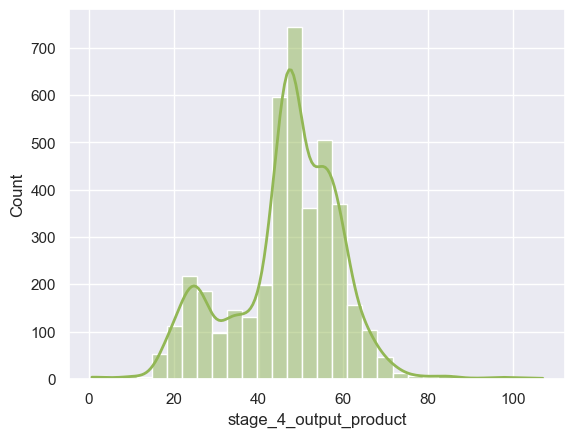

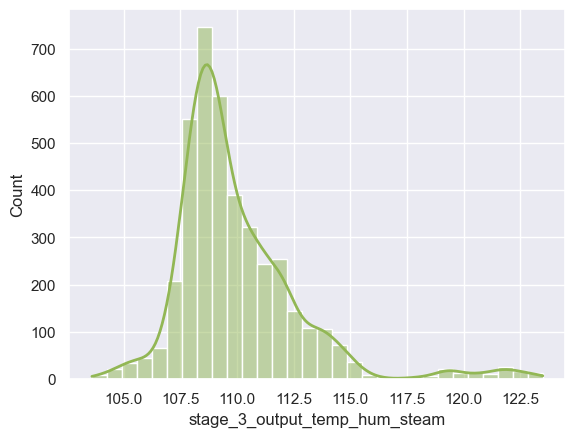

In [ ]:
sns.histplot(gip_10['stage_4_output_product'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()
sns.histplot(gip_10['stage_3_output_temp_hum_steam'], kde=True, bins=30, color=color_for_histplot, line_kws=line)
plt.show()

In [ ]:
raspder(gip_10)

Параметр Распределение
0         stage_4_output_product  ненормальное
1  stage_3_output_temp_hum_steam  ненормальное

оба распределения не нормальные

H₀ = Между медианами stage_4_output_product и stage_3_output_temp_hum_steam различия носят исключительно случайных характер

H₁ = Между медианами stage_4_output_product и stage_3_output_temp_hum_steam различия носят не случайных характер

In [237]:
cor, p_value = mannwhitneyu(gip_10['stage_4_output_product'], gip_10['stage_3_output_temp_hum_steam'])
cor, p_value

(260.5, 0.0)

P-уровень: 3.896116535795647e-24 > 0.05, отклоняем нулевую гипотезу и принимаем альтернативную гипотезу, поскольку результаты статистического теста показывают, что связь является статистически значимой.

## Регрессионное моделирование

### Моделирование для доли опасного газа

In [ ]:
df.dropna(subset=['stage_4_output_danger_gas'], inplace=True)

In [ ]:
features = [
  'stage_1_output_konv_avd',
  'stage_2_input_water_sum',
  'stage_2_output_top_temp',
  'stage_2_output_top_vacuum',
  'stage_3_input_pressure',
  'stage_3_input_steam',
  'stage_3_output_temp_top',
  'stage_4_input_polymer',
  'stage_4_input_steam',
  'stage_4_input_water',
  'stage_4_output_dry_residue_avg'


]
target = 'stage_4_output_danger_gas'

X = df[features]
y = df[target]

Подбор гипер-параметров для ExtraTrees

In [ ]:
'''X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
param_distributions = {
    'n_estimators': [300, 500, 1000, 3000, 5000],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 5],
    'max_features': ['sqrt', 'log2', 0.5, 1.0],
    'bootstrap': [False, True]
}

et = ExtraTreesRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=et,
    param_distributions=param_distributions,
    n_iter=150,            
    scoring='r2', 
    cv=5,  
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_) 
print("Best score:", -random_search.best_score_)'''

'X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\nparam_distributions = {\n    \'n_estimators\': [300, 500, 1000, 3000, 5000],\n    \'max_depth\': [None, 10, 20, 30, 40],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 3, 5],\n    \'max_features\': [\'sqrt\', \'log2\', 0.5, 1.0],\n    \'bootstrap\': [False, True]\n}\n\net = ExtraTreesRegressor(random_state=42)\n\nrandom_search = RandomizedSearchCV(\n    estimator=et,\n    param_distributions=param_distributions,\n    n_iter=150,            \n    scoring=\'r2\', \n    cv=5,  \n    verbose=2,\n    n_jobs=-1,\n    random_state=42\n)\n\nrandom_search.fit(X_train, y_train)\n\nprint("Best params:", random_search.best_params_) \nprint("Best score:", -random_search.best_score_)'

Подбор гипер-параметров для CatBoost

In [ ]:
'''
model = CatBoostRegressor(random_state=42, verbose=0)

param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 0.5, 1]
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)'''

'\nmodel = CatBoostRegressor(random_state=42, verbose=0)\n\nparam_grid = {\n    \'iterations\': [500, 1000],\n    \'learning_rate\': [0.01, 0.05, 0.1],\n    \'depth\': [4, 6, 8],\n    \'l2_leaf_reg\': [1, 3, 5, 7],\n    \'bagging_temperature\': [0, 0.5, 1]\n}\n\ngrid_search = GridSearchCV(model, param_grid, cv=3, scoring=\'neg_mean_squared_error\', n_jobs=-1)\ngrid_search.fit(X_train, y_train)\n\nprint("Лучшие параметры:", grid_search.best_params_)'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
models = {

    'CatBoost': CatBoostRegressor(iterations=1000, learning_rate=0.01, l2_leaf_reg=6, depth=6,  random_state=42, bagging_temperature=0, verbose=0),
    'ExtraTrees': ExtraTreesRegressor(n_estimators=500, min_samples_split=2, max_features='sqrt', max_depth=40, bootstrap=False, n_jobs=-1, random_state=42)

}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mape_val = mape(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'--- {name} ---')
    print('MAE:', mae)
    print('MAPE:', mape_val)
    print('R2:', r2)
    print()
    '''  
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        print('\nFeature Importances:')
        print(importance_df)
    else:
        print('\nFeature importances not available for this model.')
    '''
    print('\n' + '-'*50 + '\n')

--- CatBoost ---
MAE: 0.02501566103987716
MAPE: 21.237778399155612
R2: 0.27258826509127543


--------------------------------------------------

--- ExtraTrees ---
MAE: 0.024033262032085563
MAPE: 20.586843066319023
R2: 0.31657883784179885


--------------------------------------------------



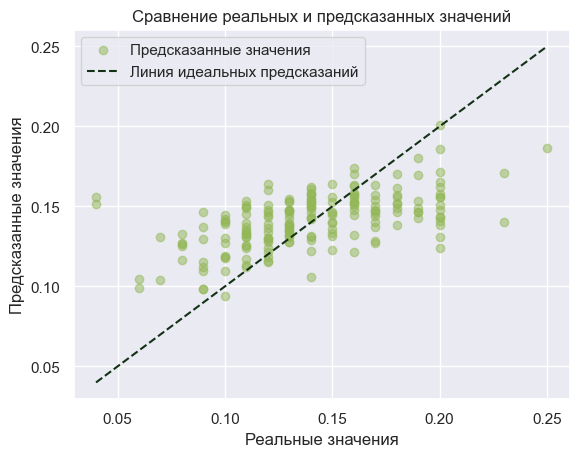

In [241]:
real_values = y_test
predicted_values = y_pred

plt.scatter(real_values, predicted_values, color=color_for_histplot, alpha=0.5, label='Предсказанные значения')
plt.plot([min(real_values), max(real_values)], [min(real_values), max(real_values)], color=color_for_line, linestyle='--', label='Линия идеальных предсказаний')


plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение реальных и предсказанных значений')
plt.legend()
plt.grid(True)
plt.show()